### Imports

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

### Load Data

In [82]:
df = pd.read_csv('data/laptop_price_wf.csv', encoding = 'latin-1', index_col = [0])
df.head()

laptop_ID Company      Product   TypeName  Inches  \
0          1   Apple  MacBook Pro  Ultrabook    13.3   
1          2   Apple  Macbook Air  Ultrabook    13.3   
2          3      HP       250 G6   Notebook    15.6   
3          4   Apple  MacBook Pro  Ultrabook    15.4   
4          5   Apple  MacBook Pro  Ultrabook    13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Price_euros  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS      1339.69   
1  128GB Flash Storage        Intel HD Graphics 6000  macOS       898.94   
2            256GB SSD         Intel HD Graphics 620  No OS       575.00   
3            512GB SSD            AMD Radeon Pro 455  macOS      2537.45   
4            256GB SSD  Intel Iris Plus Graphics 650  macOS      1803.60   

   Weight_fl  
0       1.37  
1       1.34  
2       1.86  
3       1.83  
4       1.37

### Function for Preprocessing

In [83]:
# function that preprocesses dataframe
def process_dataframe(input_df):
    # screen resolution
    input_df['Touchscreen'] = np.where(input_df['ScreenResolution'].str.contains('Touchscreen', case = False, na = False), 1, 0)
    input_df['ScreenResolution'] = input_df.apply(lambda x: x['ScreenResolution'][-8:], axis = 1)
    input_df['ScreenResolution'] = input_df['ScreenResolution'].str.replace(' ', '')
    # cpu
    input_df['Cpu'] = input_df['Cpu'].str.replace('Core', '')
    input_df['Cpu'] = input_df['Cpu'].str.split().str[:2].str.join(sep = ' ')
    input_df['Cpu'] = input_df['Cpu'].str.split().str[1:].str.join(sep = ' ')
    # memory
    input_df['ssd'] = np.where(input_df['Memory'].str.contains('ssd|hybrid', case = False, na = False), 1, 0)
    input_df['Memory'] = input_df['Memory'].str.replace('1.0', '1', regex = False)
    input_df['Memory'] = input_df['Memory'].str.replace('1TB', '1024')
    input_df['Memory'] = input_df['Memory'].str.replace('2TB', '2048')
    input_df['Memory'] = input_df['Memory'].str.replace('GB', '')
    input_df['Memory'] = input_df['Memory'].str.split().apply(lambda x: [a for a in x if a.isdigit()])
    input_df['Memory'] = input_df['Memory'].apply(lambda x: [int(a) for a in x])
    input_df['Memory'] = input_df['Memory'].apply(lambda x: sum(x))
    # gpu
    input_df['Gpu'] = input_df['Gpu'].str.split().str[:2].str.join(sep = ' ')
    input_df['Gpu'] = input_df['Gpu'].str.split().str[1:].str.join(sep = ' ')
    # drop columns
    input_df = input_df.drop(['Product', 'laptop_ID'], axis = 1)
    return input_df

### Function for Pipeline

In [84]:
# Data Preprocessing
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('stdscaler', StandardScaler())])

# Applying Transformer 
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Gpu', 'OpSys']),
    ('numerical_preprocessing', numerical_preprocessing, ['Inches', 'Memory', 'Weight_fl'])
])

# function that produces performance of pipeline with indicated model
def main(input_df, input_model):
    pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', input_model)
    ])

    X = df.drop('Price_euros', axis = 1)
    y = df['Price_euros']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print('MSE is: ' + str(mean_squared_error(y_test, y_pred)))
    print('RMSE is: ' + str(sqrt(mean_squared_error(y_test, y_pred))))
    print('MAE is: ' + str(mean_absolute_error(y_test, y_pred)))
    print('R2 score is: ' + str(r2_score(y_test, y_pred)))

In [85]:
# preprocess dataframe
df = process_dataframe(df)

# droping rows of frequency < 3
counts_col2 = df.groupby('Cpu')['Cpu'].transform(len)
counts_col3 = df.groupby('Gpu')['Gpu'].transform(len)
mask = (counts_col2 > 3) & (counts_col3 > 3)
df = df[mask]

In [86]:
# linear regression
model = LinearRegression()
main(df, model)

MSE is: 106138.25731158059
RMSE is: 325.78866971025957
MAE is: 233.05011026539074
R2 score is: 0.7846611149698784


In [87]:
# stochastic gradient descent regression
model = SGDRegressor()
main(df, model)

MSE is: 108293.00243858574
RMSE is: 329.07902157169747
MAE is: 233.37948916408354
R2 score is: 0.780289454600411


In [15]:
# K-nearest neighbors regression
model = KNeighborsRegressor()
main(df, model)

MSE is: 97652.13115458025
RMSE is: 312.49340977783874
MAE is: 206.20712962962963
R2 score is: 0.8018782145450947


In [88]:
# random forest regression
model = RandomForestRegressor()
main(df, model)

MSE is: 93517.79254918755
RMSE is: 305.80678957339643
MAE is: 207.11933203822838
R2 score is: 0.8102661783968915


In [89]:
# xgboost regression
model = GradientBoostingRegressor()
main(df, model)

MSE is: 101825.8706000213
RMSE is: 319.10166185719135
MAE is: 219.56572164035467
R2 score is: 0.7934103121943986


In [90]:
# support vector machine regression
model = SVR()
main(df, model)

MSE is: 505031.12816916406
RMSE is: 710.655421543496
MAE is: 508.97951655806116
R2 score is: -0.02463374470334667


### Grid Search

In [27]:
# setting up parameters grid
param_grid = {'model__n_estimators': [100, 500, 1000],
              'model__max_depth': [None, 10, 20],
              'model__min_samples_split': [2, 5, 10],
              'model__min_samples_leaf': [1, 2, 4],
              'model__max_features': ['sqrt', None, 1],
              'model__bootstrap': [True, False]}

# best performing model
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor())
])
X = df.drop('Price_euros', axis = 1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Creating gridsearch object
grid_search = GridSearchCV(pipeline, param_grid, verbose = 10, refit = True)

In [28]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5; 1/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 1/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.787 total time=   0.2s
[CV 2/5; 1/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 1/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 1/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 1/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 1/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 1/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.847 total time=   0.2s
[CV 5/5; 1/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 1/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 2/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 2/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.785 total time=   1.4s
[CV 2/5; 2/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 2/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.3s
[CV 3/5; 2/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 2/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.3s
[CV 4/5; 2/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 2/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.838 total time=   1.3s
[CV 5/5; 2/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 2/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.3s
[CV 1/5; 3/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 3/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.787 total time=   2.7s
[CV 2/5; 3/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 3/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.6s
[CV 3/5; 3/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 3/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.7s
[CV 4/5; 3/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 3/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.842 total time=   2.7s
[CV 5/5; 3/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 3/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.7s
[CV 1/5; 4/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 4/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.755 total time=   0.1s
[CV 2/5; 4/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans


[CV 2/5; 4/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 4/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 4/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 4/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 4/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.839 total time=   0.1s
[CV 5/5; 4/486] START model__bootstrap=True, 

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 5/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.777 total time=   0.9s
[CV 2/5; 5/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 5/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 3/5; 5/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 5/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 4/5; 5/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 5/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.829 total time=   0.8s
[CV 5/5; 5/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 5/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 1/5; 6/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 6/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.767 total time=   1.7s
[CV 2/5; 6/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 6/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 3/5; 6/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 6/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 4/5; 6/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 6/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.827 total time=   1.7s
[CV 5/5; 6/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 6/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 1/5; 7/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 7/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.750 total time=   0.1s
[CV 2/5; 7/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 7/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 7/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 7/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 7/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 7/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.811 total time=   0.1s
[CV 5/5; 7/486] START model__bootstrap=Tr

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 8/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.753 total time=   0.6s
[CV 2/5; 8/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 8/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 8/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 8/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 8/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 8/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.809 total time=   0.6s
[CV 5/5; 8/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 8/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 9/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 9/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.759 total time=   1.3s
[CV 2/5; 9/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 9/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 3/5; 9/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 9/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 4/5; 9/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 9/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.812 total time=   1.3s
[CV 5/5; 9/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 9/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 10/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 10/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.722 total time=   0.1s
[CV 2/5; 10/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 10/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 10/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 10/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 10/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 10/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.800 total time=   0.1s
[CV 5/5; 10/486] START model__bootstrap=T

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 11/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.717 total time=   0.7s
[CV 2/5; 11/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 11/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 11/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 11/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 11/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 11/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.804 total time=   0.7s
[CV 5/5; 11/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 11/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 12/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 12/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.722 total time=   1.4s
[CV 2/5; 12/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 12/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 3/5; 12/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 12/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 12/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 12/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.795 total time=   1.4s
[CV 5/5; 12/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 12/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 13/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 13/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.718 total time=   0.1s
[CV 2/5; 13/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 13/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 13/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 13/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 13/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 13/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.795 total time=   0.1s
[CV 5/5; 13/486] START model__bootstrap=T

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 14/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.719 total time=   0.6s
[CV 2/5; 14/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 14/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 14/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 14/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 14/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 14/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.796 total time=   0.6s
[CV 5/5; 14/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 14/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 15/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 15/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.723 total time=   1.4s
[CV 2/5; 15/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 15/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 3/5; 15/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 15/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 4/5; 15/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 15/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.798 total time=   1.4s
[CV 5/5; 15/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 15/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 16/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 16/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.719 total time=   0.1s
[CV 2/5; 16/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 16/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 16/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 16/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 16/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 16/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.791 total time=   0.0s
[CV 5/5; 16/486] START model__bootst

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 17/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.716 total time=   0.6s
[CV 2/5; 17/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 17/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 17/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 17/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 17/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 17/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.788 total time=   0.5s
[CV 5/5; 17/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 17/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 18/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 18/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.714 total time=   1.2s
[CV 2/5; 18/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 18/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 18/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 18/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 18/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 18/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.786 total time=   1.2s
[CV 5/5; 18/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 18/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 19/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 19/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.675 total time=   0.0s
[CV 2/5; 19/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 19/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 19/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 19/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 19/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 19/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.758 total time=   0.0s
[CV 5/5; 19/486] START model__bootstrap=T

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 20/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.685 total time=   0.5s
[CV 2/5; 20/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 20/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 20/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 20/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 20/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 20/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.759 total time=   0.5s
[CV 5/5; 20/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 20/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 21/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 21/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.682 total time=   1.1s
[CV 2/5; 21/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 21/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 21/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 21/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 21/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 21/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.757 total time=   1.1s
[CV 5/5; 21/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 21/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 22/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 22/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.681 total time=   0.0s
[CV 2/5; 22/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 22/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 22/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 22/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 22/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 22/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.755 total time=   0.0s
[CV 5/5; 22/486] START model__bootstrap=T

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 23/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.678 total time=   0.5s
[CV 2/5; 23/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 23/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 23/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 23/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 23/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 23/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.755 total time=   0.5s
[CV 5/5; 23/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 23/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 24/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 24/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.681 total time=   1.1s
[CV 2/5; 24/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 24/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 24/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 24/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 24/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 24/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.753 total time=   1.1s
[CV 5/5; 24/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 24/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 25/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 25/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.678 total time=   0.0s
[CV 2/5; 25/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 25/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 25/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 25/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 25/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 25/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.762 total time=   0.0s
[CV 5/5; 25/486] START model__bootst

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 26/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.678 total time=   0.5s
[CV 2/5; 26/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 26/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 26/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 26/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 26/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 26/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.753 total time=   0.5s
[CV 5/5; 26/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 26/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 27/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 27/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.675 total time=   1.1s
[CV 2/5; 27/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 27/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 27/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 27/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 27/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 27/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.755 total time=   1.1s
[CV 5/5; 27/486] START model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 27/486] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 28/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 28/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.761 total time=   0.6s
[CV 2/5; 28/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 28/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 28/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 28/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 28/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 28/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.820 total time=   0.6s
[CV 5/5; 28/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 28/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 29/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 29/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.775 total time=   3.3s
[CV 2/5; 29/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 29/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 3/5; 29/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 29/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.2s
[CV 4/5; 29/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 29/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.822 total time=   3.4s
[CV 5/5; 29/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 29/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 1/5; 30/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 30/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.771 total time=   6.6s
[CV 2/5; 30/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 30/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.7s
[CV 3/5; 30/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 30/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 4/5; 30/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 30/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.825 total time=   6.8s
[CV 5/5; 30/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 30/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 1/5; 31/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 31/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.749 total time=   0.4s
[CV 2/5; 31/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 31/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 31/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 31/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 31/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 31/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.830 total time=   0.5s
[CV 5/5; 31/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 31/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 32/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 32/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.762 total time=   2.6s
[CV 2/5; 32/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 32/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 3/5; 32/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 32/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 4/5; 32/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 32/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.822 total time=   2.6s
[CV 5/5; 32/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 32/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 1/5; 33/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 33/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.763 total time=   5.2s
[CV 2/5; 33/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 33/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.2s
[CV 3/5; 33/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 33/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.2s
[CV 4/5; 33/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 33/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.824 total time=   5.4s
[CV 5/5; 33/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 33/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.2s
[CV 1/5; 34/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 34/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.744 total time=   0.3s
[CV 2/5; 34/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 34/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 34/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 34/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 34/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 34/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.819 total time=   0.3s
[CV 5/5; 34/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 34/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 35/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 35/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.754 total time=   1.9s
[CV 2/5; 35/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 35/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 35/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 35/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 4/5; 35/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 35/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.819 total time=   2.0s
[CV 5/5; 35/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 35/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 36/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 36/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.748 total time=   4.0s
[CV 2/5; 36/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 36/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 3/5; 36/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 36/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 4/5; 36/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 36/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.819 total time=   4.1s
[CV 5/5; 36/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 36/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 1/5; 37/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 37/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.706 total time=   0.4s
[CV 2/5; 37/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 37/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 37/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 37/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 37/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 37/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.812 total time=   0.4s
[CV 5/5; 37/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 37/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 38/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 38/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.703 total time=   2.4s
[CV 2/5; 38/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 38/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 3/5; 38/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 38/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.4s
[CV 4/5; 38/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 38/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.818 total time=   2.5s
[CV 5/5; 38/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 38/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 1/5; 39/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 39/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.703 total time=   5.1s
[CV 2/5; 39/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 39/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 3/5; 39/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 39/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 4/5; 39/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 39/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.821 total time=   5.1s
[CV 5/5; 39/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 39/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 1/5; 40/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 40/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.694 total time=   0.4s
[CV 2/5; 40/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 40/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 40/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 40/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 40/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 40/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.810 total time=   0.4s
[CV 5/5; 40/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 40/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 41/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 41/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.701 total time=   2.3s
[CV 2/5; 41/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 41/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 3/5; 41/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 41/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 4/5; 41/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 41/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.820 total time=   2.4s
[CV 5/5; 41/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 41/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 1/5; 42/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 42/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.700 total time=   4.7s
[CV 2/5; 42/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 42/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 3/5; 42/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 42/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 4/5; 42/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 42/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.818 total time=   4.9s
[CV 5/5; 42/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 42/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 1/5; 43/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 43/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.691 total time=   0.3s
[CV 2/5; 43/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 43/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 43/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 43/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 43/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 43/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.810 total time=   0.3s
[CV 5/5; 43/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 43/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 44/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 44/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.695 total time=   1.8s
[CV 2/5; 44/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 44/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 44/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 44/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 44/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 44/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.805 total time=   1.8s
[CV 5/5; 44/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 44/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 45/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 45/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.693 total time=   3.6s
[CV 2/5; 45/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 45/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 3/5; 45/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 45/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 4/5; 45/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 45/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.811 total time=   3.7s
[CV 5/5; 45/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 45/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 1/5; 46/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 46/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.652 total time=   0.3s
[CV 2/5; 46/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 46/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 46/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 46/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 46/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 46/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.801 total time=   0.3s
[CV 5/5; 46/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 46/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 47/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 47/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.644 total time=   1.8s
[CV 2/5; 47/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 47/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 47/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 47/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.7s
[CV 4/5; 47/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 47/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.796 total time=   1.8s
[CV 5/5; 47/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 47/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 48/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 48/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.648 total time=   3.6s
[CV 2/5; 48/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 48/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 3/5; 48/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 48/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 4/5; 48/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 48/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.796 total time=   3.7s
[CV 5/5; 48/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 48/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 1/5; 49/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 49/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.646 total time=   0.3s
[CV 2/5; 49/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 49/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 49/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 49/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 49/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 49/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.789 total time=   0.3s
[CV 5/5; 49/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 49/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 50/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 50/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.648 total time=   1.8s
[CV 2/5; 50/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 50/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 50/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 50/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 4/5; 50/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 50/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.795 total time=   2.0s
[CV 5/5; 50/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 50/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 51/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 51/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.650 total time=   4.0s
[CV 2/5; 51/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 51/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 3/5; 51/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 51/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 4/5; 51/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 51/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.795 total time=   4.5s
[CV 5/5; 51/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 51/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 1/5; 52/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 52/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.645 total time=   0.2s
[CV 2/5; 52/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 52/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 52/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 52/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 52/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 52/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.790 total time=   0.3s
[CV 5/5; 52/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 52/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 53/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 53/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.646 total time=   1.6s
[CV 2/5; 53/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 53/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 53/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 53/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.0s
[CV 4/5; 53/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 53/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.798 total time=   1.7s
[CV 5/5; 53/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 53/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 1/5; 54/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 54/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.646 total time=   3.4s
[CV 2/5; 54/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 54/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 3/5; 54/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 54/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 4/5; 54/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 54/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.795 total time=   3.4s
[CV 5/5; 54/486] START model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 54/486] END model__bootstrap=True, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.4s
[CV 1/5; 55/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 55/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.781 total time=   0.2s
[CV 2/5; 55/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 55/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 55/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 55/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 55/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 55/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.836 total time=   0.2s
[CV 5/5; 55/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 55/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 56/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 56/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.784 total time=   1.2s
[CV 2/5; 56/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 56/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.2s
[CV 3/5; 56/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 56/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.1s
[CV 4/5; 56/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 56/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.836 total time=   1.4s
[CV 5/5; 56/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 56/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.2s
[CV 1/5; 57/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 57/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.786 total time=   2.5s
[CV 2/5; 57/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 57/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.5s
[CV 3/5; 57/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 57/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.5s
[CV 4/5; 57/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 57/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.838 total time=   2.6s
[CV 5/5; 57/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 57/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.7s
[CV 1/5; 58/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 58/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.773 total time=   0.1s
[CV 2/5; 58/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 58/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 58/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 58/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 58/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 58/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.811 total time=   0.1s
[CV 5/5; 58/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 58/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 1/5; 59/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 59/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.761 total time=   0.7s
[CV 2/5; 59/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 59/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 59/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 59/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 59/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 59/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.812 total time=   0.7s
[CV 5/5; 59/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 59/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 60/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 60/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.767 total time=   1.6s
[CV 2/5; 60/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 60/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 60/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 60/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 4/5; 60/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 60/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.815 total time=   1.6s
[CV 5/5; 60/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 60/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 1/5; 61/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 61/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.730 total time=   0.0s
[CV 2/5; 61/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 61/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 61/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 61/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 61/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 61/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.777 total time=   0.0s
[CV 5/5; 61/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 62/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.743 total time=   0.5s
[CV 2/5; 62/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 62/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 62/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 62/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 62/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 62/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.786 total time=   0.6s
[CV 5/5; 62/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 62/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 63/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 63/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.744 total time=   1.2s
[CV 2/5; 63/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 63/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 3/5; 63/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 63/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 4/5; 63/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 63/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.787 total time=   1.3s
[CV 5/5; 63/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 63/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 1/5; 64/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 64/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.387 total time=   0.0s
[CV 2/5; 64/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 64/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 64/486] START model__bootstrap=True, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 64/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 64/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 64/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.392 total time=   0.0s
[CV 5/5; 64/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 64/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 65/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 65/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.376 total time=   0.4s
[CV 2/5; 65/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 65/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 65/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 65/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 65/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 65/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.430 total time=   0.4s
[CV 5/5; 65/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 65/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 66/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 66/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.389 total time=   0.9s
[CV 2/5; 66/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 66/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 66/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 66/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/5; 66/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 66/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.429 total time=   0.9s
[CV 5/5; 66/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 66/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 67/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 67/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.402 total time=   0.0s
[CV 2/5; 67/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 67/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 67/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 67/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 67/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 67/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.450 total time=   0.0s
[CV 5/5; 67/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 67/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 68/486] START model__bootstrap=True, model__max

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 68/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 68/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 68/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 68/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 68/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.429 total time=   0.4s
[CV 5/5; 68/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 68/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 69/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 69/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.374 total time=   0.8s
[CV 2/5; 69/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 69/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 69/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 69/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 69/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 69/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.429 total time=   0.8s
[CV 5/5; 69/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 69/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 70/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 70/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.391 total time=   0.0s
[CV 2/5; 70/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 70/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 70/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 70/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 70/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 70/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.420 total time=   0.0s
[CV 5/5; 70/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 71/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.376 total time=   0.4s
[CV 2/5; 71/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 71/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 71/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 71/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 71/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 71/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.412 total time=   0.3s
[CV 5/5; 71/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 71/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 72/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 72/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.371 total time=   0.8s
[CV 2/5; 72/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 72/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 72/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 72/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 72/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 72/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.418 total time=   0.8s
[CV 5/5; 72/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 72/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 73/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 73/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.194 total time=   0.0s
[CV 2/5; 73/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 73/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 73/486] START model__bootstrap=True, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans


[CV 3/5; 73/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 73/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 73/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.255 total time=   0.0s
[CV 5/5; 73/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 73/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 74/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 74/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 74/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 74/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 74/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 74/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.239 total time=   0.3s
[CV 5/5; 74/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 74/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 75/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 75/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.225 total time=   0.7s
[CV 2/5; 75/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 75/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 75/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 75/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 75/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 75/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.242 total time=   0.8s
[CV 5/5; 75/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 75/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 76/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 76/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.188 total time=   0.0s
[CV 2/5; 76/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 76/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 76/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 76/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 76/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 76/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.236 total time=   0.0s
[CV 5/5; 76/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 76/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 77/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 77/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.256 total time=   0.4s
[CV 2/5; 77/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 77/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 77/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 77/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 77/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 77/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.233 total time=   0.4s
[CV 5/5; 77/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 77/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 78/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 78/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.229 total time=   0.7s
[CV 2/5; 78/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 78/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 78/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 78/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 78/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 78/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.231 total time=   0.7s
[CV 5/5; 78/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 78/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 79/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 79/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.219 total time=   0.0s
[CV 2/5; 79/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 79/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 79/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 79/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 79/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 79/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.267 total time=   0.0s
[CV 5/5; 79/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 79/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 80/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 80/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 80/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 80/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 80/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 80/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.212 total time=   0.3s
[CV 5/5; 80/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 80/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 81/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 81/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.220 total time=   0.7s
[CV 2/5; 81/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 81/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 81/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 81/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 81/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 81/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.248 total time=   0.7s
[CV 5/5; 81/486] START model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 81/486] END model__bootstrap=True, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 82/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 82/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.740 total time=   0.1s
[CV 2/5; 82/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 82/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 82/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 82/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 82/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 82/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.807 total time=   0.1s
[CV 5/5; 82/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 83/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.751 total time=   0.7s
[CV 2/5; 83/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 83/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 83/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 83/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 83/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 83/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.805 total time=   0.7s
[CV 5/5; 83/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 83/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 84/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 84/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.744 total time=   1.5s
[CV 2/5; 84/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 84/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 84/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 84/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 84/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 84/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.806 total time=   1.4s
[CV 5/5; 84/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 84/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 85/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 85/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.739 total time=   0.0s
[CV 2/5; 85/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 85/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 85/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 85/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 85/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 85/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.796 total time=   0.0s
[CV 5/5; 85/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 86/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.742 total time=   0.6s
[CV 2/5; 86/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 86/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 86/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 86/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 86/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 86/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.803 total time=   0.6s
[CV 5/5; 86/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 86/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 87/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 87/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.737 total time=   1.2s
[CV 2/5; 87/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 87/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 87/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 87/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 87/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 87/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.801 total time=   1.3s
[CV 5/5; 87/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 87/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 1/5; 88/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 88/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.709 total time=   0.0s
[CV 2/5; 88/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 88/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 88/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 88/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 88/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 88/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.794 total time=   0.0s
[CV 5/5; 88/486] START model__bootstrap=True, 

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 89/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.737 total time=   0.5s
[CV 2/5; 89/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 89/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 89/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 89/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 89/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 89/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.790 total time=   0.5s
[CV 5/5; 89/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 89/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 90/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 90/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.734 total time=   1.2s
[CV 2/5; 90/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 90/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 90/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 90/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 90/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 90/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.790 total time=   1.1s
[CV 5/5; 90/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 90/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 91/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 91/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.706 total time=   0.0s
[CV 2/5; 91/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 91/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 91/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 91/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 91/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 91/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.778 total time=   0.0s
[CV 5/5; 91/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 92/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.703 total time=   0.5s
[CV 2/5; 92/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 92/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 92/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 92/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 92/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 92/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.777 total time=   0.5s
[CV 5/5; 92/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 92/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 93/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 93/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.704 total time=   1.1s
[CV 2/5; 93/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 93/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 93/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 93/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 93/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 93/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.784 total time=   1.2s
[CV 5/5; 93/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 93/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 94/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 94/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.698 total time=   0.1s
[CV 2/5; 94/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 94/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 94/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 94/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 94/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 94/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.778 total time=   0.0s
[CV 5/5; 94/486] START model__bootstrap=True, model

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 95/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.707 total time=   0.5s
[CV 2/5; 95/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 95/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 95/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 95/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 95/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 95/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.780 total time=   0.5s
[CV 5/5; 95/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 95/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 96/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 96/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.706 total time=   1.2s
[CV 2/5; 96/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 96/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 96/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 96/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 96/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 96/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.784 total time=   1.1s
[CV 5/5; 96/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 96/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 97/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 97/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.710 total time=   0.0s
[CV 2/5; 97/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 97/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 97/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 97/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 97/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 97/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.769 total time=   0.0s
[CV 5/5; 97/486] START model__bootstrap=True, 

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 98/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.694 total time=   0.5s
[CV 2/5; 98/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 98/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 98/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 98/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 98/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 98/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.777 total time=   0.5s
[CV 5/5; 98/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 98/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 99/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 99/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.704 total time=   1.0s
[CV 2/5; 99/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 99/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 99/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 99/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 99/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 99/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.774 total time=   1.0s
[CV 5/5; 99/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 99/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 100/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 100/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.673 total time=   0.0s
[CV 2/5; 100/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 100/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 100/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 100/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 100/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 100/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.743 total time=   0.0s
[CV 5/5; 100/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 101/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.674 total time=   0.5s
[CV 2/5; 101/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 101/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 101/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 101/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 101/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 101/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.751 total time=   0.5s
[CV 5/5; 101/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 101/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 102/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 102/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.676 total time=   1.0s
[CV 2/5; 102/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 102/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 102/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 102/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 102/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 102/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.749 total time=   1.1s
[CV 5/5; 102/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 102/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 103/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 103/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.668 total time=   0.0s
[CV 2/5; 103/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 103/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 103/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 103/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 103/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 103/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.746 total time=   0.0s
[CV 5/5; 103/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 104/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.677 total time=   0.5s
[CV 2/5; 104/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 104/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 104/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 104/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 104/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 104/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.747 total time=   0.5s
[CV 5/5; 104/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 104/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 105/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 105/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.678 total time=   1.1s
[CV 2/5; 105/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 105/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 105/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 105/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 105/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 105/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.749 total time=   1.0s
[CV 5/5; 105/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 105/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 106/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 106/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.673 total time=   0.0s
[CV 2/5; 106/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 106/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 106/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 106/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 106/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 106/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.749 total time=   0.0s
[CV 5/5; 106/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 107/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.668 total time=   0.4s
[CV 2/5; 107/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 107/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 107/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 107/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 107/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 107/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.748 total time=   0.4s
[CV 5/5; 107/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 107/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 108/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 108/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.677 total time=   1.0s
[CV 2/5; 108/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 108/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/5; 108/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 108/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 108/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 108/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.746 total time=   1.0s
[CV 5/5; 108/486] START model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 108/486] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 109/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 109/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.762 total time=   0.4s
[CV 2/5; 109/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 109/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 109/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 109/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 109/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 109/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.807 total time=   0.3s
[CV 5/5; 109/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 109/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 110/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 110/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.758 total time=   2.1s
[CV 2/5; 110/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 110/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.0s
[CV 3/5; 110/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 110/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.1s
[CV 4/5; 110/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 110/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.809 total time=   2.0s
[CV 5/5; 110/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 110/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.0s
[CV 1/5; 111/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 111/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.756 total time=   4.4s
[CV 2/5; 111/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 111/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.4s
[CV 3/5; 111/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 111/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 4/5; 111/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 111/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.808 total time=   4.1s
[CV 5/5; 111/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 111/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 1/5; 112/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 112/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.753 total time=   0.3s
[CV 2/5; 112/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 112/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 112/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 112/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 112/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 112/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.811 total time=   0.3s
[CV 5/5; 112/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 112/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 113/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 113/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.758 total time=   1.9s
[CV 2/5; 113/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 113/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 113/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 113/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 113/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 113/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.807 total time=   1.8s
[CV 5/5; 113/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 113/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 114/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 114/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.755 total time=   3.9s
[CV 2/5; 114/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 114/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 3/5; 114/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 114/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 4/5; 114/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 114/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.809 total time=   3.9s
[CV 5/5; 114/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 114/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 1/5; 115/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 115/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.743 total time=   0.2s
[CV 2/5; 115/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 115/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 115/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 115/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 115/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 115/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.803 total time=   0.2s
[CV 5/5; 115/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 115/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 116/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 116/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.743 total time=   1.6s
[CV 2/5; 116/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 116/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 3/5; 116/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 116/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 4/5; 116/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 116/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.801 total time=   1.5s
[CV 5/5; 116/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 116/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 117/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 117/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.741 total time=   3.4s
[CV 2/5; 117/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 117/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 3/5; 117/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 117/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 4/5; 117/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 117/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.806 total time=   3.4s
[CV 5/5; 117/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 117/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 1/5; 118/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 118/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.695 total time=   0.3s
[CV 2/5; 118/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 118/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 118/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 118/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 118/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 118/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.812 total time=   0.3s
[CV 5/5; 118/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 118/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 119/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 119/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.696 total time=   2.1s
[CV 2/5; 119/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 119/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 119/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 119/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.9s
[CV 4/5; 119/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 119/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.810 total time=   1.9s
[CV 5/5; 119/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 119/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 120/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 120/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.702 total time=   4.0s
[CV 2/5; 120/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 120/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 3/5; 120/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 120/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 4/5; 120/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 120/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.807 total time=   4.0s
[CV 5/5; 120/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 120/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 1/5; 121/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 121/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.709 total time=   0.3s
[CV 2/5; 121/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 121/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 121/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 121/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 121/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 121/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.808 total time=   0.3s
[CV 5/5; 121/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 121/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 122/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 122/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.702 total time=   1.9s
[CV 2/5; 122/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 122/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.1s
[CV 3/5; 122/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 122/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 4/5; 122/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 122/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.809 total time=   2.1s
[CV 5/5; 122/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 122/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 1/5; 123/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 123/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.698 total time=   4.1s
[CV 2/5; 123/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 123/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.4s
[CV 3/5; 123/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 123/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 4/5; 123/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 123/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.809 total time=   3.8s
[CV 5/5; 123/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 123/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 1/5; 124/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 124/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.700 total time=   0.3s
[CV 2/5; 124/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 124/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 124/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 124/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 124/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 124/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.797 total time=   0.3s
[CV 5/5; 124/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 124/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 125/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 125/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.685 total time=   1.8s
[CV 2/5; 125/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 125/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 3/5; 125/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 125/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 4/5; 125/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 125/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.797 total time=   1.5s
[CV 5/5; 125/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 125/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.5s
[CV 1/5; 126/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 126/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.693 total time=   3.3s
[CV 2/5; 126/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 126/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 3/5; 126/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 126/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 4/5; 126/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 126/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.800 total time=   3.1s
[CV 5/5; 126/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 126/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 1/5; 127/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 127/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.633 total time=   0.3s
[CV 2/5; 127/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 127/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 127/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 127/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 127/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 127/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.798 total time=   0.2s
[CV 5/5; 127/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 127/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 128/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 128/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.650 total time=   1.7s
[CV 2/5; 128/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 128/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.7s
[CV 3/5; 128/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 128/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.6s
[CV 4/5; 128/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 128/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.794 total time=   1.6s
[CV 5/5; 128/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 128/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.6s
[CV 1/5; 129/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 129/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.650 total time=   3.3s
[CV 2/5; 129/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 129/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 3/5; 129/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 129/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 4/5; 129/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 129/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.793 total time=   3.3s
[CV 5/5; 129/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 129/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.3s
[CV 1/5; 130/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 130/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.653 total time=   0.3s
[CV 2/5; 130/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 130/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 130/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 130/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 130/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 130/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.795 total time=   0.3s
[CV 5/5; 130/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 130/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 131/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 131/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.647 total time=   1.6s
[CV 2/5; 131/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 131/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.6s
[CV 3/5; 131/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 131/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.6s
[CV 4/5; 131/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 131/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.796 total time=   1.6s
[CV 5/5; 131/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 131/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.5s
[CV 1/5; 132/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 132/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.650 total time=   3.4s
[CV 2/5; 132/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 132/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 3/5; 132/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 132/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.4s
[CV 4/5; 132/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 132/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.793 total time=   3.3s
[CV 5/5; 132/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 132/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 1/5; 133/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 133/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.647 total time=   0.3s
[CV 2/5; 133/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 133/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 133/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 133/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 133/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 133/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.794 total time=   0.3s
[CV 5/5; 133/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 133/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 134/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 134/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.641 total time=   1.5s
[CV 2/5; 134/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 134/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.4s
[CV 3/5; 134/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 134/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.5s
[CV 4/5; 134/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 134/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.792 total time=   1.5s
[CV 5/5; 134/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 134/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.5s
[CV 1/5; 135/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 135/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.646 total time=   3.1s
[CV 2/5; 135/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 135/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.0s
[CV 3/5; 135/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 135/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.0s
[CV 4/5; 135/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 135/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.790 total time=   3.1s
[CV 5/5; 135/486] START model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 135/486] END model__bootstrap=True, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.0s
[CV 1/5; 136/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 136/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.593 total time=   0.0s
[CV 2/5; 136/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 136/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 136/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 136/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 136/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 136/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.633 total time=   0.0s
[CV 5/5; 136/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 136/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 137/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 137/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.618 total time=   0.4s
[CV 2/5; 137/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 137/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 137/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 137/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 137/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 137/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.643 total time=   0.4s
[CV 5/5; 137/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 137/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 138/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 138/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.616 total time=   1.0s
[CV 2/5; 138/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 138/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/5; 138/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 138/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 138/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 138/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.636 total time=   1.1s
[CV 5/5; 138/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 138/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 139/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 139/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.601 total time=   0.0s
[CV 2/5; 139/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 139/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 139/486] START model__bootstrap=True, model__max_de

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 139/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 139/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 139/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.649 total time=   0.0s
[CV 5/5; 139/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 139/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 140/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 140/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 140/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 140/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 140/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 140/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.632 total time=   0.4s
[CV 5/5; 140/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 140/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 141/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 141/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.604 total time=   0.8s
[CV 2/5; 141/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 141/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 141/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 141/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 141/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 141/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.625 total time=   0.8s
[CV 5/5; 141/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 141/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 142/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 142/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.579 total time=   0.0s
[CV 2/5; 142/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 142/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 142/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 142/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 142/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 142/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.609 total time=   0.0s
[CV 5/5; 142/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 142/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 143/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 143/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 143/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 143/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 143/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 143/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.623 total time=   0.3s
[CV 5/5; 143/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 143/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 144/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 144/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.599 total time=   0.8s
[CV 2/5; 144/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 144/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 144/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 144/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 144/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 144/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.623 total time=   0.8s
[CV 5/5; 144/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 144/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 145/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 145/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.321 total time=   0.0s
[CV 2/5; 145/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 145/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 145/486] START model__bootstrap=True, model__max_d

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 145/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 145/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 145/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.363 total time=   0.0s
[CV 5/5; 145/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 145/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 146/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 146/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 146/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 146/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 146/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 146/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.382 total time=   0.3s
[CV 5/5; 146/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 146/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 147/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 147/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.362 total time=   0.7s
[CV 2/5; 147/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 147/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 147/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 147/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 147/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 147/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.383 total time=   0.7s
[CV 5/5; 147/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 147/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 148/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 148/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.363 total time=   0.0s
[CV 2/5; 148/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 148/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 148/486] START model__bootstrap=True, model__max_de

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 148/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 148/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 148/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.386 total time=   0.0s
[CV 5/5; 148/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 148/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 149/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 149/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 149/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 149/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 149/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 149/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.394 total time=   0.4s
[CV 5/5; 149/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 149/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 150/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 150/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.358 total time=   0.7s
[CV 2/5; 150/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 150/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 150/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 150/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 150/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 150/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.382 total time=   0.7s
[CV 5/5; 150/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 150/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 151/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 151/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.366 total time=   0.0s
[CV 2/5; 151/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 151/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 151/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 151/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 151/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 151/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.401 total time=   0.0s
[CV 5/5; 151/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 151/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 152/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 152/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 152/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 152/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 152/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 152/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.374 total time=   0.3s
[CV 5/5; 152/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 152/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 153/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 153/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.354 total time=   0.8s
[CV 2/5; 153/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 153/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 153/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 153/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 153/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 153/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.388 total time=   0.7s
[CV 5/5; 153/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 153/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 154/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 154/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.203 total time=   0.0s
[CV 2/5; 154/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 154/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 154/486] START model__bootstrap=True, model__max_d

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 154/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 154/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 154/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.194 total time=   0.0s
[CV 5/5; 154/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 154/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 155/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 155/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 155/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 155/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 155/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 155/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.219 total time=   0.3s
[CV 5/5; 155/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 155/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 156/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 156/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.226 total time=   0.7s
[CV 2/5; 156/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 156/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 156/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 156/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 156/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 156/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.238 total time=   0.7s
[CV 5/5; 156/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 156/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 157/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 157/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.265 total time=   0.0s
[CV 2/5; 157/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 157/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 157/486] START model__bootstrap=True, model__max_de

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 157/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 157/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 157/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.268 total time=   0.0s
[CV 5/5; 157/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 157/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 158/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 158/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 158/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 158/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 158/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 158/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.236 total time=   0.3s
[CV 5/5; 158/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 158/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 159/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 159/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.224 total time=   0.7s
[CV 2/5; 159/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 159/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 159/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 159/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 159/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 159/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.227 total time=   0.7s
[CV 5/5; 159/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 159/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 160/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 160/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.242 total time=   0.0s
[CV 2/5; 160/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 160/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 160/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 160/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 160/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 160/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.289 total time=   0.0s
[CV 5/5; 160/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 160/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 161/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 161/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 161/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 161/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 161/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 161/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.226 total time=   0.3s
[CV 5/5; 161/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 161/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 162/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 162/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.234 total time=   0.7s
[CV 2/5; 162/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 162/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 162/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 162/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 162/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 162/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.247 total time=   0.7s
[CV 5/5; 162/486] START model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 162/486] END model__bootstrap=True, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 163/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 163/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.797 total time=   0.2s
[CV 2/5; 163/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 163/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 163/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 163/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 163/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 163/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.834 total time=   0.2s
[CV 5/5; 163/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 163/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 164/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 164/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.775 total time=   1.2s
[CV 2/5; 164/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 164/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.2s
[CV 3/5; 164/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 164/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.3s
[CV 4/5; 164/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 164/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.845 total time=   1.3s
[CV 5/5; 164/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 164/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.3s
[CV 1/5; 165/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 165/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.782 total time=   2.9s
[CV 2/5; 165/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 165/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.8s
[CV 3/5; 165/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 165/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.7s
[CV 4/5; 165/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 165/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.840 total time=   2.9s
[CV 5/5; 165/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 165/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.6s
[CV 1/5; 166/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 166/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.758 total time=   0.1s
[CV 2/5; 166/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 166/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 166/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 166/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 166/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 166/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.832 total time=   0.1s
[CV 5/5; 166/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 167/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.765 total time=   0.8s
[CV 2/5; 167/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 167/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 3/5; 167/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 167/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 4/5; 167/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 167/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.831 total time=   0.8s
[CV 5/5; 167/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 167/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 1/5; 168/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 168/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.772 total time=   1.8s
[CV 2/5; 168/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 168/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 3/5; 168/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 168/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 4/5; 168/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 168/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.827 total time=   1.7s
[CV 5/5; 168/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 168/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 1/5; 169/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 169/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.749 total time=   0.1s
[CV 2/5; 169/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 169/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 169/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 169/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 169/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 169/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.805 total time=   0.1s
[CV 5/5; 169/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 170/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.758 total time=   0.6s
[CV 2/5; 170/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 170/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 170/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 170/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 170/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 170/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.808 total time=   0.6s
[CV 5/5; 170/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 170/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 171/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 171/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.757 total time=   1.5s
[CV 2/5; 171/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 171/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 3/5; 171/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 171/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 171/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 171/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.810 total time=   1.3s
[CV 5/5; 171/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 171/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 172/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 172/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.722 total time=   0.1s
[CV 2/5; 172/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 172/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 172/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 172/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 172/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 172/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.798 total time=   0.1s
[CV 5/5; 172/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 173/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.722 total time=   0.7s
[CV 2/5; 173/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 173/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 173/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 173/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 173/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 173/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.803 total time=   0.7s
[CV 5/5; 173/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 173/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 174/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 174/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.725 total time=   1.5s
[CV 2/5; 174/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 174/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 3/5; 174/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 174/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 174/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 174/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.797 total time=   1.4s
[CV 5/5; 174/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 174/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 175/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 175/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.712 total time=   0.1s
[CV 2/5; 175/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 175/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 175/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 175/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 175/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 175/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.803 total time=   0.1s
[CV 5/5; 175/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 176/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.724 total time=   0.6s
[CV 2/5; 176/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 176/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 176/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 176/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 176/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 176/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.800 total time=   0.6s
[CV 5/5; 176/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 176/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 177/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 177/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.721 total time=   1.4s
[CV 2/5; 177/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 177/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 3/5; 177/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 177/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 4/5; 177/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 177/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.800 total time=   1.4s
[CV 5/5; 177/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 177/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 178/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 178/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.722 total time=   0.0s
[CV 2/5; 178/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 178/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 178/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 178/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 178/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 178/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.791 total time=   0.0s
[CV 5/5; 178/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 179/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.707 total time=   0.5s
[CV 2/5; 179/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 179/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 179/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 179/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 179/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 179/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.786 total time=   0.5s
[CV 5/5; 179/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 179/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 180/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 180/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.713 total time=   1.2s
[CV 2/5; 180/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 180/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 180/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 180/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 180/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 180/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.789 total time=   1.2s
[CV 5/5; 180/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 180/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 181/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 181/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.685 total time=   0.1s
[CV 2/5; 181/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 181/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 181/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 181/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 181/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 181/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.757 total time=   0.0s
[CV 5/5; 181/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 182/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.678 total time=   0.7s
[CV 2/5; 182/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 182/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 182/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 182/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 182/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 182/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.754 total time=   0.5s
[CV 5/5; 182/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 182/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 183/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 183/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.680 total time=   1.3s
[CV 2/5; 183/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 183/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 183/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 183/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 4/5; 183/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 183/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.756 total time=   1.2s
[CV 5/5; 183/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 183/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 184/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 184/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.667 total time=   0.0s
[CV 2/5; 184/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 184/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 184/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 184/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 184/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 184/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.758 total time=   0.1s
[CV 5/5; 184/486] START model__bootstrap=True,

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 185/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.673 total time=   0.5s
[CV 2/5; 185/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 185/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 185/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 185/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 185/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 185/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.755 total time=   0.5s
[CV 5/5; 185/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 185/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 186/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 186/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.678 total time=   1.2s
[CV 2/5; 186/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 186/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 3/5; 186/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 186/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 4/5; 186/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 186/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.758 total time=   1.4s
[CV 5/5; 186/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 186/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 1/5; 187/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 187/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.672 total time=   0.1s
[CV 2/5; 187/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 187/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 187/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 187/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 187/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 187/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.753 total time=   0.1s
[CV 5/5; 187/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 188/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.680 total time=   0.6s
[CV 2/5; 188/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 188/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 188/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 188/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 188/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 188/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.753 total time=   0.5s
[CV 5/5; 188/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 188/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 189/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 189/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.681 total time=   1.2s
[CV 2/5; 189/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 189/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 189/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 189/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 189/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 189/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.756 total time=   1.2s
[CV 5/5; 189/486] START model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 189/486] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 190/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 190/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.777 total time=   0.6s
[CV 2/5; 190/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 190/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 190/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 190/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 190/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 190/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.823 total time=   0.6s
[CV 5/5; 190/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 190/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 191/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 191/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.771 total time=   3.4s
[CV 2/5; 191/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 191/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.4s
[CV 3/5; 191/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 191/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 4/5; 191/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 191/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.823 total time=   3.4s
[CV 5/5; 191/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 191/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 1/5; 192/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 192/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.770 total time=   6.6s
[CV 2/5; 192/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 192/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 3/5; 192/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 192/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 4/5; 192/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 192/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.825 total time=   6.7s
[CV 5/5; 192/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 192/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 1/5; 193/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 193/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.754 total time=   0.4s
[CV 2/5; 193/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 193/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.5s
[CV 3/5; 193/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 193/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 193/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 193/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.825 total time=   0.5s
[CV 5/5; 193/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 193/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 194/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 194/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.772 total time=   2.6s
[CV 2/5; 194/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 194/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 3/5; 194/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 194/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 4/5; 194/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 194/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.825 total time=   2.6s
[CV 5/5; 194/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 194/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 1/5; 195/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 195/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.761 total time=   5.2s
[CV 2/5; 195/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 195/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.4s
[CV 3/5; 195/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 195/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.3s
[CV 4/5; 195/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 195/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.826 total time=   5.4s
[CV 5/5; 195/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 195/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   5.2s
[CV 1/5; 196/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 196/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.738 total time=   0.3s
[CV 2/5; 196/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 196/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 196/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 196/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 196/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 196/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.809 total time=   0.3s
[CV 5/5; 196/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 196/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 197/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 197/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.750 total time=   2.0s
[CV 2/5; 197/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 197/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.0s
[CV 3/5; 197/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 197/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 4/5; 197/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 197/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.816 total time=   2.0s
[CV 5/5; 197/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 197/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 198/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 198/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.748 total time=   4.0s
[CV 2/5; 198/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 198/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 3/5; 198/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 198/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 4/5; 198/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 198/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.820 total time=   4.2s
[CV 5/5; 198/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 198/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 1/5; 199/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 199/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.718 total time=   0.4s
[CV 2/5; 199/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 199/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 199/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 199/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 199/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 199/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.822 total time=   0.4s
[CV 5/5; 199/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 199/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 200/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 200/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.711 total time=   2.5s
[CV 2/5; 200/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 200/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 3/5; 200/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 200/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 4/5; 200/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 200/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.820 total time=   2.5s
[CV 5/5; 200/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 200/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 1/5; 201/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 201/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.704 total time=   5.0s
[CV 2/5; 201/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 201/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 3/5; 201/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 201/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 4/5; 201/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 201/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.817 total time=   5.1s
[CV 5/5; 201/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 201/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 1/5; 202/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 202/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.689 total time=   0.4s
[CV 2/5; 202/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 202/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 202/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 202/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 202/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 202/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.817 total time=   0.4s
[CV 5/5; 202/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 202/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 203/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 203/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.710 total time=   2.3s
[CV 2/5; 203/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 203/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 3/5; 203/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 203/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 4/5; 203/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 203/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.822 total time=   2.4s
[CV 5/5; 203/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 203/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.3s
[CV 1/5; 204/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 204/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.704 total time=   4.7s
[CV 2/5; 204/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 204/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 3/5; 204/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 204/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 4/5; 204/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 204/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.818 total time=   4.8s
[CV 5/5; 204/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 204/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 1/5; 205/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 205/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.679 total time=   0.3s
[CV 2/5; 205/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 205/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 205/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 205/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 205/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 205/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.807 total time=   0.3s
[CV 5/5; 205/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 205/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 206/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 206/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.695 total time=   1.8s
[CV 2/5; 206/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 206/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 206/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 206/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 206/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 206/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.806 total time=   1.8s
[CV 5/5; 206/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 206/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 207/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 207/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.693 total time=   3.7s
[CV 2/5; 207/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 207/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 3/5; 207/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 207/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 4/5; 207/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 207/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.809 total time=   3.7s
[CV 5/5; 207/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 207/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 1/5; 208/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 208/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.648 total time=   0.3s
[CV 2/5; 208/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 208/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 208/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 208/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 208/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 208/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.788 total time=   0.3s
[CV 5/5; 208/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 208/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 209/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 209/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.649 total time=   1.8s
[CV 2/5; 209/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 209/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.8s
[CV 3/5; 209/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 209/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 209/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 209/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.794 total time=   1.8s
[CV 5/5; 209/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 209/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 210/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 210/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.646 total time=   3.6s
[CV 2/5; 210/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 210/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 3/5; 210/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 210/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 4/5; 210/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 210/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.794 total time=   4.0s
[CV 5/5; 210/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 210/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 1/5; 211/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 211/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.630 total time=   0.3s
[CV 2/5; 211/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 211/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 211/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 211/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 211/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 211/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.792 total time=   0.3s
[CV 5/5; 211/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 211/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 212/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 212/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.653 total time=   1.8s
[CV 2/5; 212/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 212/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 212/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 212/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 212/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 212/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.796 total time=   1.9s
[CV 5/5; 212/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 212/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 1/5; 213/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 213/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.653 total time=   3.7s
[CV 2/5; 213/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 213/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 3/5; 213/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 213/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 4/5; 213/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 213/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.797 total time=   3.8s
[CV 5/5; 213/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 213/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 1/5; 214/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 214/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.666 total time=   0.3s
[CV 2/5; 214/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 214/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 214/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 214/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 214/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 214/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.788 total time=   0.3s
[CV 5/5; 214/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 214/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 215/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 215/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.650 total time=   1.6s
[CV 2/5; 215/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 215/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 3/5; 215/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 215/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 4/5; 215/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 215/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.793 total time=   1.7s
[CV 5/5; 215/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 215/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.6s
[CV 1/5; 216/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 216/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.644 total time=   3.3s
[CV 2/5; 216/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 216/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.4s
[CV 3/5; 216/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 216/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.4s
[CV 4/5; 216/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 216/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.791 total time=   3.4s
[CV 5/5; 216/486] START model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 216/486] END model__bootstrap=True, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.3s
[CV 1/5; 217/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 217/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.769 total time=   0.1s
[CV 2/5; 217/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 217/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 217/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 217/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 217/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 217/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.818 total time=   0.1s
[CV 5/5; 217/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 217/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 1/5; 218/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 218/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.775 total time=   0.9s
[CV 2/5; 218/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 218/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.9s
[CV 3/5; 218/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 218/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.9s
[CV 4/5; 218/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 218/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.826 total time=   0.9s
[CV 5/5; 218/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 218/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.9s
[CV 1/5; 219/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 219/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.772 total time=   2.0s
[CV 2/5; 219/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 219/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.9s
[CV 3/5; 219/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 219/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.9s
[CV 4/5; 219/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 219/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.824 total time=   2.0s
[CV 5/5; 219/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 219/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.9s
[CV 1/5; 220/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 220/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.753 total time=   0.1s
[CV 2/5; 220/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 220/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 220/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 220/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 220/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 220/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.801 total time=   0.1s
[CV 5/5; 220/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 221/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.756 total time=   0.6s
[CV 2/5; 221/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 221/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 221/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 221/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 221/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 221/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.799 total time=   0.6s
[CV 5/5; 221/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 221/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 222/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 222/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.757 total time=   1.3s
[CV 2/5; 222/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 222/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 3/5; 222/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 222/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 4/5; 222/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 222/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.802 total time=   1.3s
[CV 5/5; 222/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 222/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 1/5; 223/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 223/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.726 total time=   0.0s
[CV 2/5; 223/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 223/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 223/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 223/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 223/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 223/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.774 total time=   0.0s
[CV 5/5; 223/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 224/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.730 total time=   0.5s
[CV 2/5; 224/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 224/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 224/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 224/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 224/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 224/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.774 total time=   0.5s
[CV 5/5; 224/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 224/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 225/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 225/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.728 total time=   1.0s
[CV 2/5; 225/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 225/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 225/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 225/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 225/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 225/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.774 total time=   1.1s
[CV 5/5; 225/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 225/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 226/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 226/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.370 total time=   0.0s
[CV 2/5; 226/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 226/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 226/486] START model__bootstrap=True, model__max_d

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 226/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 226/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 226/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.400 total time=   0.0s
[CV 5/5; 226/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 226/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 227/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 227/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 227/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 227/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 227/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 227/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.430 total time=   0.3s
[CV 5/5; 227/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 227/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 228/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 228/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.376 total time=   0.8s
[CV 2/5; 228/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 228/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 228/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 228/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 228/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 228/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.431 total time=   0.8s
[CV 5/5; 228/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 228/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 229/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 229/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.345 total time=   0.0s
[CV 2/5; 229/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 229/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 229/486] START model__bootstrap=True, model__max_de

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 229/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 229/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 229/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.412 total time=   0.0s
[CV 5/5; 229/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 229/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 230/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 230/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 230/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 230/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 230/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 230/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.443 total time=   0.4s
[CV 5/5; 230/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 230/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 231/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 231/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.386 total time=   0.8s
[CV 2/5; 231/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 231/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 231/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 231/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 231/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 231/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.413 total time=   0.8s
[CV 5/5; 231/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 231/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 232/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 232/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.388 total time=   0.0s
[CV 2/5; 232/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 232/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 232/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 232/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 232/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 232/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.446 total time=   0.0s
[CV 5/5; 232/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 232/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 233/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 233/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 233/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 233/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 233/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 233/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.395 total time=   0.3s
[CV 5/5; 233/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 233/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 234/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 234/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.390 total time=   0.7s
[CV 2/5; 234/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 234/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 3/5; 234/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 234/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 234/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 234/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.411 total time=   0.7s
[CV 5/5; 234/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 234/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 235/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 235/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.209 total time=   0.0s
[CV 2/5; 235/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 235/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 235/486] START model__bootstrap=True, model__max_d

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 235/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 235/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 235/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.264 total time=   0.0s
[CV 5/5; 235/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 235/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 236/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 236/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 236/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 236/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 236/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 236/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.239 total time=   0.3s
[CV 5/5; 236/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 236/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 237/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 237/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.228 total time=   0.7s
[CV 2/5; 237/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 237/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 237/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 237/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 237/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 237/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.226 total time=   0.7s
[CV 5/5; 237/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 237/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 238/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 238/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.215 total time=   0.0s
[CV 2/5; 238/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 238/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 238/486] START model__bootstrap=True, model__max_de

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 238/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 238/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 238/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.221 total time=   0.0s
[CV 5/5; 238/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 238/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 239/486] START model__bootstrap=True, model__max_dep

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 239/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 239/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 239/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 239/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 239/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.244 total time=   0.3s
[CV 5/5; 239/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 239/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 240/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 240/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.225 total time=   0.7s
[CV 2/5; 240/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 240/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 240/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 240/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 240/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 240/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.216 total time=   0.7s
[CV 5/5; 240/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 240/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 241/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 241/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.251 total time=   0.0s
[CV 2/5; 241/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 241/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 241/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 241/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 241/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 241/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.245 total time=   0.0s
[CV 5/5; 241/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 241/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 242/486] START model__bootstrap=True, model__ma

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 242/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 242/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 242/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 242/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 242/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.233 total time=   0.3s
[CV 5/5; 242/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 242/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 243/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 243/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.243 total time=   0.7s
[CV 2/5; 243/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 243/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 243/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 243/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 243/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 243/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.229 total time=   0.7s
[CV 5/5; 243/486] START model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 243/486] END model__bootstrap=True, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 244/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 244/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.809 total time=   0.3s
[CV 2/5; 244/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 244/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 244/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 244/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 244/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 244/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.837 total time=   0.3s
[CV 5/5; 244/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 244/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 245/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 245/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.800 total time=   1.7s
[CV 2/5; 245/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 245/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.6s
[CV 3/5; 245/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 245/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.6s
[CV 4/5; 245/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 245/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.840 total time=   1.7s
[CV 5/5; 245/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 245/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.7s
[CV 1/5; 246/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 246/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.803 total time=   3.4s
[CV 2/5; 246/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 246/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.3s
[CV 3/5; 246/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 246/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.3s
[CV 4/5; 246/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 246/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.838 total time=   3.5s
[CV 5/5; 246/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 246/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.4s
[CV 1/5; 247/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 247/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.787 total time=   0.1s
[CV 2/5; 247/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 247/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 247/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 247/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 247/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 247/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.839 total time=   0.1s
[CV 5/5; 247/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 247/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 1/5; 248/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 248/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.792 total time=   1.0s
[CV 2/5; 248/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 248/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.0s
[CV 3/5; 248/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 248/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.0s
[CV 4/5; 248/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 248/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.842 total time=   1.0s
[CV 5/5; 248/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 248/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.0s
[CV 1/5; 249/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 249/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.792 total time=   2.1s
[CV 2/5; 249/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 249/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.0s
[CV 3/5; 249/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 249/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.0s
[CV 4/5; 249/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 249/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.837 total time=   2.0s
[CV 5/5; 249/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 249/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.0s
[CV 1/5; 250/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 250/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.774 total time=   0.1s
[CV 2/5; 250/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 250/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 250/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 250/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 250/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 250/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.822 total time=   0.1s
[CV 5/5; 250/486] START mo

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 251/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.781 total time=   0.7s
[CV 2/5; 251/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 251/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 251/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 251/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 251/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 251/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.829 total time=   0.7s
[CV 5/5; 251/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 251/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 252/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 252/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.780 total time=   1.5s
[CV 2/5; 252/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 252/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 252/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 252/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 252/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 252/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.826 total time=   1.4s
[CV 5/5; 252/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 252/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 253/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 253/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.749 total time=   0.1s
[CV 2/5; 253/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 253/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 253/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 253/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 253/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 253/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.821 total time=   0.1s
[CV 5/5; 253/486] START model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 254/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.742 total time=   0.7s
[CV 2/5; 254/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 254/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 254/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 254/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 254/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 254/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.824 total time=   0.7s
[CV 5/5; 254/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 254/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 255/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 255/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.746 total time=   1.6s
[CV 2/5; 255/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 255/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 3/5; 255/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 255/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 4/5; 255/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 255/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.823 total time=   1.6s
[CV 5/5; 255/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 255/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 1/5; 256/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 256/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.744 total time=   0.1s
[CV 2/5; 256/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 256/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 256/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 256/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 256/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 256/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.810 total time=   0.1s
[CV 5/5; 256/486] START model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 257/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.745 total time=   0.7s
[CV 2/5; 257/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 257/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 257/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 257/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 257/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 257/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.817 total time=   0.7s
[CV 5/5; 257/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 257/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 258/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 258/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.743 total time=   1.5s
[CV 2/5; 258/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 258/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 258/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 258/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 258/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 258/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.818 total time=   1.5s
[CV 5/5; 258/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 258/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 259/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 259/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.728 total time=   0.0s
[CV 2/5; 259/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 259/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 259/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 259/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 259/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 259/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.803 total time=   0.0s
[CV 5/5; 259/486] START mo

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 260/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.739 total time=   0.5s
[CV 2/5; 260/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 260/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 260/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 260/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 260/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 260/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.807 total time=   0.5s
[CV 5/5; 260/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 260/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 261/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 261/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.737 total time=   1.2s
[CV 2/5; 261/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 261/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 261/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 261/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 261/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 261/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.810 total time=   1.2s
[CV 5/5; 261/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 261/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 262/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 262/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.696 total time=   0.0s
[CV 2/5; 262/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 262/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 262/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 262/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 262/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 262/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.778 total time=   0.0s
[CV 5/5; 262/486] START model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 263/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.700 total time=   0.5s
[CV 2/5; 263/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 263/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 263/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 263/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 263/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 263/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.777 total time=   0.5s
[CV 5/5; 263/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 263/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 264/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 264/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.696 total time=   1.0s
[CV 2/5; 264/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 264/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 264/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 264/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 264/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 264/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.780 total time=   1.0s
[CV 5/5; 264/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 264/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 265/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 265/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.692 total time=   0.0s
[CV 2/5; 265/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 265/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 265/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 265/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 265/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 265/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.778 total time=   0.0s
[CV 5/5; 265/486] START model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 266/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.695 total time=   0.5s
[CV 2/5; 266/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 266/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 266/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 266/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 266/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 266/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.780 total time=   0.5s
[CV 5/5; 266/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 266/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 267/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 267/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.694 total time=   1.0s
[CV 2/5; 267/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 267/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 267/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 267/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 267/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 267/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.779 total time=   1.0s
[CV 5/5; 267/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 267/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 268/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 268/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.708 total time=   0.0s
[CV 2/5; 268/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 268/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 268/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 268/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 268/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 268/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.771 total time=   0.0s
[CV 5/5; 268/486] START mo

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 269/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.697 total time=   0.5s
[CV 2/5; 269/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 269/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 269/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 269/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 269/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 269/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.776 total time=   0.4s
[CV 5/5; 269/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 269/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 270/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 270/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.700 total time=   1.0s
[CV 2/5; 270/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 270/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 270/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 270/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/5; 270/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 270/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.777 total time=   1.0s
[CV 5/5; 270/486] START model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 270/486] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/5; 271/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 271/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.726 total time=   0.8s
[CV 2/5; 271/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 271/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 3/5; 271/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 271/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 4/5; 271/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 271/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.694 total time=   0.8s
[CV 5/5; 271/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 271/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 1/5; 272/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 272/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.721 total time=   4.4s
[CV 2/5; 272/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 272/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.5s
[CV 3/5; 272/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 272/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.4s
[CV 4/5; 272/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 272/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.697 total time=   4.5s
[CV 5/5; 272/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 272/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.3s
[CV 1/5; 273/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 273/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.724 total time=   8.9s
[CV 2/5; 273/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 273/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   9.1s
[CV 3/5; 273/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 273/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   8.8s
[CV 4/5; 273/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 273/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.698 total time=   9.0s
[CV 5/5; 273/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 273/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   8.8s
[CV 1/5; 274/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 274/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.728 total time=   0.6s
[CV 2/5; 274/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 274/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 274/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 274/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 274/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 274/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.705 total time=   0.6s
[CV 5/5; 274/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 274/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 275/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 275/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.728 total time=   3.4s
[CV 2/5; 275/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 275/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.5s
[CV 3/5; 275/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 275/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 4/5; 275/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 275/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.706 total time=   3.5s
[CV 5/5; 275/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 275/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 1/5; 276/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 276/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.728 total time=   6.8s
[CV 2/5; 276/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 276/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   7.1s
[CV 3/5; 276/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 276/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 4/5; 276/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 276/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.705 total time=   7.1s
[CV 5/5; 276/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 276/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 1/5; 277/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 277/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.710 total time=   0.4s
[CV 2/5; 277/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 277/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 277/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 277/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 277/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 277/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.729 total time=   0.5s
[CV 5/5; 277/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 277/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 278/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 278/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.707 total time=   2.5s
[CV 2/5; 278/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 278/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.5s
[CV 3/5; 278/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 278/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.6s
[CV 4/5; 278/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 278/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.729 total time=   2.6s
[CV 5/5; 278/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 278/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.6s
[CV 1/5; 279/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 279/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.706 total time=   5.1s
[CV 2/5; 279/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 279/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.1s
[CV 3/5; 279/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 279/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.2s
[CV 4/5; 279/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 279/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.729 total time=   5.3s
[CV 5/5; 279/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 279/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.1s
[CV 1/5; 280/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 280/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.436 total time=   0.5s
[CV 2/5; 280/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 280/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 280/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 280/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 280/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 280/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.663 total time=   0.6s
[CV 5/5; 280/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 280/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 281/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 281/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.436 total time=   3.1s
[CV 2/5; 281/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 281/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 3/5; 281/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 281/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.2s
[CV 4/5; 281/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 281/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.661 total time=   3.3s
[CV 5/5; 281/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 281/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.2s
[CV 1/5; 282/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 282/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.436 total time=   6.3s
[CV 2/5; 282/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 282/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 3/5; 282/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 282/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.5s
[CV 4/5; 282/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 282/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.662 total time=   6.6s
[CV 5/5; 282/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 282/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.4s
[CV 1/5; 283/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 283/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.436 total time=   0.5s
[CV 2/5; 283/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 283/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.5s
[CV 3/5; 283/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 283/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 283/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 283/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.660 total time=   0.6s
[CV 5/5; 283/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 283/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 284/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 284/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.436 total time=   3.0s
[CV 2/5; 284/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 284/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 3/5; 284/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 284/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.1s
[CV 4/5; 284/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 284/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.660 total time=   3.1s
[CV 5/5; 284/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 284/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.0s
[CV 1/5; 285/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 285/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.436 total time=   6.0s
[CV 2/5; 285/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 285/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 3/5; 285/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 285/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.8s
[CV 4/5; 285/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 285/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.661 total time=   6.9s
[CV 5/5; 285/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 285/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   7.8s
[CV 1/5; 286/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 286/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.498 total time=   0.4s
[CV 2/5; 286/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 286/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 286/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 286/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.5s
[CV 4/5; 286/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 286/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.694 total time=   0.5s
[CV 5/5; 286/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 286/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.5s
[CV 1/5; 287/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 287/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.498 total time=   2.8s
[CV 2/5; 287/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 287/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.7s
[CV 3/5; 287/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 287/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.8s
[CV 4/5; 287/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 287/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.692 total time=   2.9s
[CV 5/5; 287/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 287/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.7s
[CV 1/5; 288/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 288/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.498 total time=   5.3s
[CV 2/5; 288/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 288/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.7s
[CV 3/5; 288/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 288/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.5s
[CV 4/5; 288/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 288/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.692 total time=   5.6s
[CV 5/5; 288/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 288/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.4s
[CV 1/5; 289/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 289/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.497 total time=   0.4s
[CV 2/5; 289/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 289/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 289/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 289/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 289/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 289/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.737 total time=   0.4s
[CV 5/5; 289/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 289/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 290/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 290/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.497 total time=   2.5s
[CV 2/5; 290/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 290/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.7s
[CV 3/5; 290/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 290/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.5s
[CV 4/5; 290/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 290/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.737 total time=   2.5s
[CV 5/5; 290/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 290/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.7s
[CV 1/5; 291/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 291/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.497 total time=   5.3s
[CV 2/5; 291/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 291/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.6s
[CV 3/5; 291/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 291/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.8s
[CV 4/5; 291/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 291/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.737 total time=   5.3s
[CV 5/5; 291/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 291/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.9s
[CV 1/5; 292/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 292/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.497 total time=   0.4s
[CV 2/5; 292/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 292/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 292/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 292/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 292/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 292/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.737 total time=   0.4s
[CV 5/5; 292/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 292/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 293/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 293/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.497 total time=   2.3s
[CV 2/5; 293/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 293/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.4s
[CV 3/5; 293/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 293/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.4s
[CV 4/5; 293/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 293/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.737 total time=   2.3s
[CV 5/5; 293/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 293/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.4s
[CV 1/5; 294/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 294/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.497 total time=   4.6s
[CV 2/5; 294/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 294/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 3/5; 294/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 294/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 4/5; 294/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 294/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.737 total time=   4.9s
[CV 5/5; 294/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 294/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 1/5; 295/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 295/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.484 total time=   0.3s
[CV 2/5; 295/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 295/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 295/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 295/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 295/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 295/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.736 total time=   0.4s
[CV 5/5; 295/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 295/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 296/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 296/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.483 total time=   2.0s
[CV 2/5; 296/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 296/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.1s
[CV 3/5; 296/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 296/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.1s
[CV 4/5; 296/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 296/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.736 total time=   2.1s
[CV 5/5; 296/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 296/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.1s
[CV 1/5; 297/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 297/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.483 total time=   4.1s
[CV 2/5; 297/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 297/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 3/5; 297/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 297/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 4/5; 297/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 297/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.736 total time=   4.2s
[CV 5/5; 297/486] START model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 297/486] END model__bootstrap=False, model__max_depth=None, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 1/5; 298/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 298/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.800 total time=   0.2s
[CV 2/5; 298/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 298/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 298/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 298/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 298/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 298/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.833 total time=   0.3s
[CV 5/5; 298/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 298/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 299/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 299/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.805 total time=   1.8s
[CV 2/5; 299/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 299/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 3/5; 299/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 299/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 4/5; 299/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 299/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.837 total time=   1.6s
[CV 5/5; 299/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 299/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 1/5; 300/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 300/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.805 total time=   3.2s
[CV 2/5; 300/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 300/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 3/5; 300/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 300/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 4/5; 300/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 300/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.834 total time=   3.2s
[CV 5/5; 300/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 300/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.2s
[CV 1/5; 301/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 301/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.788 total time=   0.1s
[CV 2/5; 301/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 301/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 301/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 301/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 301/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 301/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.832 total time=   0.1s
[CV 5/5; 301/486] START model__bootstrap=False

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 302/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.795 total time=   0.8s
[CV 2/5; 302/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 302/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 3/5; 302/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 302/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 4/5; 302/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 302/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.830 total time=   0.8s
[CV 5/5; 302/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 302/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.8s
[CV 1/5; 303/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 303/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.797 total time=   1.7s
[CV 2/5; 303/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 303/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 3/5; 303/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 303/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 4/5; 303/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 303/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.831 total time=   1.7s
[CV 5/5; 303/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 303/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.7s
[CV 1/5; 304/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 304/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.775 total time=   0.0s
[CV 2/5; 304/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 304/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 304/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 304/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 304/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 304/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.808 total time=   0.0s
[CV 5/5; 304/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 305/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.769 total time=   0.5s
[CV 2/5; 305/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 305/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 305/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 305/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 305/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 305/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.809 total time=   0.5s
[CV 5/5; 305/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 305/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 306/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 306/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.773 total time=   1.1s
[CV 2/5; 306/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 306/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 306/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 306/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 306/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 306/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.813 total time=   1.1s
[CV 5/5; 306/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 306/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 1/5; 307/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 307/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.433 total time=   0.0s
[CV 2/5; 307/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 307/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 307/486] START model__bootstrap=Fal

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 307/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 307/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 307/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.495 total time=   0.0s
[CV 5/5; 307/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 307/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 308/486] START model__bootstrap=False

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 308/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 308/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 308/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 308/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 308/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.468 total time=   0.3s
[CV 5/5; 308/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 308/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 309/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 309/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.434 total time=   0.7s
[CV 2/5; 309/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 309/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 309/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 309/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 309/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 309/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.453 total time=   0.7s
[CV 5/5; 309/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 309/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 310/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 310/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.402 total time=   0.0s
[CV 2/5; 310/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 310/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 310/486] START model__bootstrap=Fals

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 310/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 310/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 310/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.481 total time=   0.0s
[CV 5/5; 310/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 310/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 311/486] START model__bootstrap=False

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 311/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 311/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 311/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 311/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 311/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.463 total time=   0.3s
[CV 5/5; 311/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 311/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 312/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 312/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.436 total time=   0.7s
[CV 2/5; 312/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 312/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 312/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 312/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 312/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 312/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.446 total time=   0.7s
[CV 5/5; 312/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 312/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 313/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 313/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.386 total time=   0.0s
[CV 2/5; 313/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 313/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 313/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 313/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 313/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 313/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.428 total time=   0.0s
[CV 5/5; 313/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 313/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 314/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 314/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 314/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 314/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 314/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 314/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.470 total time=   0.3s
[CV 5/5; 314/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 314/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 315/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 315/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.433 total time=   0.6s
[CV 2/5; 315/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 315/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/5; 315/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 315/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 315/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 315/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.458 total time=   0.6s
[CV 5/5; 315/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 315/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 316/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 316/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.252 total time=   0.0s
[CV 2/5; 316/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 316/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 316/486] START model__bootstrap=Fal

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 317/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.235 total time=   0.2s
[CV 2/5; 317/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 317/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 317/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 317/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 317/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 317/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.261 total time=   0.2s
[CV 5/5; 317/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 317/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 318/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 318/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.242 total time=   0.5s
[CV 2/5; 318/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 318/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 318/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 318/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 318/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 318/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.250 total time=   0.5s
[CV 5/5; 318/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 318/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 319/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 319/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.266 total time=   0.0s
[CV 2/5; 319/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 319/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 319/486] START model__bootstrap=Fals

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 320/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.242 total time=   0.2s
[CV 2/5; 320/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 320/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 320/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 320/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 320/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 320/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.285 total time=   0.2s
[CV 5/5; 320/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 320/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 321/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 321/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.246 total time=   0.5s
[CV 2/5; 321/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 321/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 321/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 321/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 321/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 321/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.277 total time=   0.6s
[CV 5/5; 321/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 321/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 322/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 322/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.256 total time=   0.0s
[CV 2/5; 322/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 322/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 322/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 323/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.232 total time=   0.2s
[CV 2/5; 323/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 323/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 323/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 323/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 323/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 323/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.265 total time=   0.2s
[CV 5/5; 323/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 323/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 324/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 324/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.247 total time=   0.5s
[CV 2/5; 324/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 324/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 324/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 324/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 324/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 324/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.254 total time=   0.5s
[CV 5/5; 324/486] START model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 324/486] END model__bootstrap=False, model__max_depth=None, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 325/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 325/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.762 total time=   0.1s
[CV 2/5; 325/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 325/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 325/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 325/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 325/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 325/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.815 total time=   0.1s
[CV 5/5; 325/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 326/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.759 total time=   0.6s
[CV 2/5; 326/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 326/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 326/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 326/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 326/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 326/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.808 total time=   0.6s
[CV 5/5; 326/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 326/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 327/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 327/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.758 total time=   1.4s
[CV 2/5; 327/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 327/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 3/5; 327/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 327/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 4/5; 327/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 327/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.810 total time=   1.4s
[CV 5/5; 327/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 327/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 328/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 328/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.738 total time=   0.0s
[CV 2/5; 328/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 328/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 328/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 328/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 328/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 328/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.814 total time=   0.0s
[CV 5/5; 328/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 329/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.752 total time=   0.5s
[CV 2/5; 329/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 329/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 329/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 329/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 329/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 329/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.808 total time=   0.5s
[CV 5/5; 329/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 329/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 330/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 330/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.753 total time=   1.1s
[CV 2/5; 330/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 330/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 330/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 330/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/5; 330/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 330/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.807 total time=   1.1s
[CV 5/5; 330/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 330/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 331/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 331/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.744 total time=   0.0s
[CV 2/5; 331/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 331/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 331/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 331/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 331/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 331/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.801 total time=   0.0s
[CV 5/5; 331/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 332/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.749 total time=   0.5s
[CV 2/5; 332/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 332/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 332/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 332/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 332/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 332/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.800 total time=   0.4s
[CV 5/5; 332/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 332/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 333/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 333/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.746 total time=   1.0s
[CV 2/5; 333/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 333/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/5; 333/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 333/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/5; 333/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 333/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.801 total time=   1.0s
[CV 5/5; 333/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 333/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/5; 334/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 334/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.713 total time=   0.0s
[CV 2/5; 334/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 334/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 334/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 334/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 334/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 334/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.790 total time=   0.0s
[CV 5/5; 334/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 335/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.719 total time=   0.5s
[CV 2/5; 335/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 335/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 335/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 335/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 335/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 335/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.798 total time=   0.5s
[CV 5/5; 335/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 335/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 336/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 336/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.722 total time=   1.0s
[CV 2/5; 336/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 336/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 336/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 336/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 336/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 336/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.798 total time=   1.1s
[CV 5/5; 336/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 336/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 337/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 337/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.720 total time=   0.0s
[CV 2/5; 337/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 337/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 337/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 337/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 337/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 337/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.789 total time=   0.0s
[CV 5/5; 337/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 338/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.717 total time=   0.5s
[CV 2/5; 338/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 338/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 338/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 338/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 338/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 338/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.796 total time=   0.5s
[CV 5/5; 338/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 338/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 339/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 339/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.720 total time=   1.0s
[CV 2/5; 339/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 339/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 339/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 339/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 339/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 339/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.795 total time=   1.0s
[CV 5/5; 339/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 339/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 340/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 340/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.718 total time=   0.0s
[CV 2/5; 340/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 340/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 340/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 340/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 340/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 340/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.792 total time=   0.0s
[CV 5/5; 340/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 341/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.718 total time=   0.4s
[CV 2/5; 341/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 341/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 341/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 341/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 341/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 341/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.791 total time=   0.4s
[CV 5/5; 341/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 341/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 342/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 342/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.717 total time=   0.9s
[CV 2/5; 342/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 342/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/5; 342/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 342/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/5; 342/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 342/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.790 total time=   0.9s
[CV 5/5; 342/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 342/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/5; 343/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 343/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.687 total time=   0.0s
[CV 2/5; 343/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 343/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 343/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 343/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 343/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 343/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.760 total time=   0.0s
[CV 5/5; 343/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 344/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.689 total time=   0.4s
[CV 2/5; 344/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 344/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 344/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 344/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 344/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 344/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.768 total time=   0.4s
[CV 5/5; 344/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 344/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 345/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 345/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.690 total time=   0.9s
[CV 2/5; 345/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 345/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 345/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 345/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 345/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 345/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.770 total time=   0.9s
[CV 5/5; 345/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 345/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 346/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 346/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.687 total time=   0.0s
[CV 2/5; 346/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 346/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 346/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 346/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 346/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 346/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.774 total time=   0.0s
[CV 5/5; 346/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 347/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.687 total time=   0.4s
[CV 2/5; 347/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 347/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 347/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 347/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 347/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 347/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.769 total time=   0.4s
[CV 5/5; 347/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 347/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 348/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 348/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.684 total time=   0.9s
[CV 2/5; 348/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 348/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 348/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 348/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 348/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 348/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.769 total time=   0.9s
[CV 5/5; 348/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 348/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 349/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 349/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.691 total time=   0.0s
[CV 2/5; 349/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 349/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 349/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 349/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 349/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 349/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.768 total time=   0.0s
[CV 5/5; 349/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 349/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 350/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 350/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.686 total time=   0.4s
[CV 2/5; 350/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 350/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 350/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 350/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 350/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 350/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.765 total time=   0.4s
[CV 5/5; 350/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 350/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 351/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 351/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.691 total time=   0.9s
[CV 2/5; 351/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 351/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 351/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 351/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 351/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 351/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.767 total time=   0.9s
[CV 5/5; 351/486] START model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 351/486] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 1/5; 352/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 352/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.719 total time=   0.4s
[CV 2/5; 352/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 352/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 352/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 352/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 352/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 352/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.682 total time=   0.4s
[CV 5/5; 352/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 352/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 353/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 353/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.719 total time=   2.4s
[CV 2/5; 353/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 353/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.2s
[CV 3/5; 353/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 353/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.3s
[CV 4/5; 353/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 353/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.682 total time=   2.3s
[CV 5/5; 353/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 353/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.3s
[CV 1/5; 354/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 354/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.724 total time=   4.8s
[CV 2/5; 354/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 354/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.4s
[CV 3/5; 354/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 354/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.6s
[CV 4/5; 354/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 354/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.678 total time=   4.7s
[CV 5/5; 354/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 354/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 1/5; 355/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 355/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.723 total time=   0.4s
[CV 2/5; 355/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 355/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 355/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 355/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 355/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 355/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.681 total time=   0.4s
[CV 5/5; 355/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 355/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 356/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 356/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.727 total time=   2.2s
[CV 2/5; 356/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 356/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 3/5; 356/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 356/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 4/5; 356/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 356/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.682 total time=   2.1s
[CV 5/5; 356/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 356/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.1s
[CV 1/5; 357/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 357/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.724 total time=   4.3s
[CV 2/5; 357/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 357/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.0s
[CV 3/5; 357/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 357/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 4/5; 357/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 357/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.681 total time=   4.2s
[CV 5/5; 357/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 357/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 1/5; 358/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 358/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.690 total time=   0.3s
[CV 2/5; 358/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 358/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 358/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 358/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 358/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 358/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.694 total time=   0.3s
[CV 5/5; 358/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 358/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 359/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 359/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.694 total time=   1.9s
[CV 2/5; 359/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 359/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 3/5; 359/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 359/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 359/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 359/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.693 total time=   1.8s
[CV 5/5; 359/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 359/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 1/5; 360/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 360/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.693 total time=   3.6s
[CV 2/5; 360/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 360/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 3/5; 360/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 360/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.2s
[CV 4/5; 360/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 360/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.694 total time=   4.3s
[CV 5/5; 360/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 360/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 1/5; 361/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 361/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.444 total time=   0.4s
[CV 2/5; 361/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 361/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 361/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 361/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 361/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 361/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.666 total time=   0.4s
[CV 5/5; 361/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 361/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 362/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 362/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.444 total time=   2.3s
[CV 2/5; 362/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 362/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.1s
[CV 3/5; 362/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 362/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.1s
[CV 4/5; 362/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 362/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.662 total time=   2.1s
[CV 5/5; 362/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 362/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.3s
[CV 1/5; 363/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 363/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.444 total time=   4.6s
[CV 2/5; 363/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 363/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.6s
[CV 3/5; 363/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 363/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.2s
[CV 4/5; 363/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 363/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.663 total time=   4.4s
[CV 5/5; 363/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 363/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   4.6s
[CV 1/5; 364/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 364/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.443 total time=   0.4s
[CV 2/5; 364/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 364/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 364/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 364/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 364/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 364/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.666 total time=   0.4s
[CV 5/5; 364/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 364/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 365/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 365/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.442 total time=   2.2s
[CV 2/5; 365/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 365/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 3/5; 365/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 365/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 4/5; 365/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 365/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.667 total time=   2.1s
[CV 5/5; 365/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 365/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.2s
[CV 1/5; 366/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 366/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.443 total time=   4.4s
[CV 2/5; 366/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 366/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 3/5; 366/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 366/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.3s
[CV 4/5; 366/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 366/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.667 total time=   4.3s
[CV 5/5; 366/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 366/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.4s
[CV 1/5; 367/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 367/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.500 total time=   0.3s
[CV 2/5; 367/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 367/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 367/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 367/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 367/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 367/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.679 total time=   0.3s
[CV 5/5; 367/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 367/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 368/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 368/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.500 total time=   1.7s
[CV 2/5; 368/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 368/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 3/5; 368/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 368/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 4/5; 368/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 368/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.680 total time=   1.7s
[CV 5/5; 368/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 368/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.7s
[CV 1/5; 369/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 369/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.500 total time=   3.5s
[CV 2/5; 369/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 369/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 3/5; 369/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 369/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 4/5; 369/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 369/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.680 total time=   3.7s
[CV 5/5; 369/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 369/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.7s
[CV 1/5; 370/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 370/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.499 total time=   0.4s
[CV 2/5; 370/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 370/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 370/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 370/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 370/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 370/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.736 total time=   0.4s
[CV 5/5; 370/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 370/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 371/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 371/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.499 total time=   2.1s
[CV 2/5; 371/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 371/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 371/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 371/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.0s
[CV 4/5; 371/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 371/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.736 total time=   2.1s
[CV 5/5; 371/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 371/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 372/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 372/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.499 total time=   4.5s
[CV 2/5; 372/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 372/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 3/5; 372/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 372/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 4/5; 372/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 372/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.736 total time=   4.0s
[CV 5/5; 372/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 372/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.9s
[CV 1/5; 373/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 373/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.499 total time=   0.4s
[CV 2/5; 373/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 373/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 373/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 373/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 373/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 373/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.736 total time=   0.3s
[CV 5/5; 373/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 373/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 374/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 374/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.499 total time=   2.1s
[CV 2/5; 374/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 374/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 374/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 374/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.0s
[CV 4/5; 374/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 374/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.736 total time=   2.0s
[CV 5/5; 374/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 374/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   1.9s
[CV 1/5; 375/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 375/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.499 total time=   4.2s
[CV 2/5; 375/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 375/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 3/5; 375/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 375/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.1s
[CV 4/5; 375/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 375/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.736 total time=   4.1s
[CV 5/5; 375/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 375/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 1/5; 376/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 376/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.485 total time=   0.3s
[CV 2/5; 376/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 376/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 3/5; 376/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 376/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 376/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 376/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.735 total time=   0.3s
[CV 5/5; 376/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 376/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 1/5; 377/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 377/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.485 total time=   1.9s
[CV 2/5; 377/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 377/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.9s
[CV 3/5; 377/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 377/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 4/5; 377/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 377/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.735 total time=   1.9s
[CV 5/5; 377/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 377/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   1.8s
[CV 1/5; 378/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 378/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.485 total time=   3.7s
[CV 2/5; 378/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 378/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.5s
[CV 3/5; 378/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 378/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.6s
[CV 4/5; 378/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 378/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.735 total time=   3.7s
[CV 5/5; 378/486] START model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 378/486] END model__bootstrap=False, model__max_depth=10, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   3.8s
[CV 1/5; 379/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 379/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.617 total time=   0.0s
[CV 2/5; 379/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 379/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 379/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 379/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 379/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 379/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.621 total time=   0.0s
[CV 5/5; 379/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 379/486] END model__bootstrap=False, model__max_depth=10, model__max_feature

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 380/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 380/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 380/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 380/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 380/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.630 total time=   0.4s
[CV 5/5; 380/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 380/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 381/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 381/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.602 total time=   0.8s
[CV 2/5; 381/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 381/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 3/5; 381/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 381/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.8s
[CV 4/5; 381/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 381/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.626 total time=   0.8s
[CV 5/5; 381/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 381/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 382/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 382/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.615 total time=   0.0s
[CV 2/5; 382/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 382/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 382/486] START model__bootstrap=False, model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 382/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 382/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 382/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.636 total time=   0.0s
[CV 5/5; 382/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 382/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 383/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 383/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 383/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 383/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 383/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 383/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.626 total time=   0.3s
[CV 5/5; 383/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 383/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 384/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 384/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.601 total time=   0.7s
[CV 2/5; 384/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 384/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 384/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 384/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 384/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 384/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.628 total time=   0.7s
[CV 5/5; 384/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 384/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 385/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 385/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.599 total time=   0.0s
[CV 2/5; 385/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 385/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 385/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 385/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 385/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 385/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.611 total time=   0.0s
[CV 5/5; 385/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 385/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 386/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 386/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 386/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 386/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 386/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 386/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.615 total time=   0.3s
[CV 5/5; 386/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 386/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 387/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 387/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.590 total time=   0.6s
[CV 2/5; 387/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 387/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/5; 387/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 387/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 387/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 387/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.605 total time=   0.6s
[CV 5/5; 387/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 387/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/5; 388/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 388/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.395 total time=   0.0s
[CV 2/5; 388/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 388/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 388/486] START model__bootstrap=False, model_

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 389/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.407 total time=   0.2s
[CV 2/5; 389/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 389/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 389/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 389/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 389/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 389/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.405 total time=   0.2s
[CV 5/5; 389/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 389/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 390/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 390/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.381 total time=   0.5s
[CV 2/5; 390/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 390/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/5; 390/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 390/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 390/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 390/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.414 total time=   0.6s
[CV 5/5; 390/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 390/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/5; 391/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 391/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.393 total time=   0.0s
[CV 2/5; 391/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 391/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 391/486] START model__bootstrap=False, model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 391/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 391/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 391/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.447 total time=   0.0s
[CV 5/5; 391/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 391/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 392/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 392/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 392/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 392/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 392/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 392/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.403 total time=   0.2s
[CV 5/5; 392/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 392/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 393/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 393/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.394 total time=   0.5s
[CV 2/5; 393/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 393/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/5; 393/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 393/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 393/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 393/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.410 total time=   0.5s
[CV 5/5; 393/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 393/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/5; 394/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 394/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.359 total time=   0.0s
[CV 2/5; 394/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 394/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 394/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 395/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.384 total time=   0.2s
[CV 2/5; 395/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 395/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 395/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 395/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 395/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 395/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.421 total time=   0.2s
[CV 5/5; 395/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 395/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 396/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 396/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.379 total time=   0.5s
[CV 2/5; 396/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 396/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 396/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 396/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 396/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 396/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.404 total time=   0.5s
[CV 5/5; 396/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 396/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 397/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 397/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.258 total time=   0.0s
[CV 2/5; 397/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 397/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 397/486] START model__bootstrap=False, model_

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 398/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.243 total time=   0.2s
[CV 2/5; 398/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 398/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 398/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 398/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 398/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 398/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.244 total time=   0.2s
[CV 5/5; 398/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 398/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 399/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 399/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.241 total time=   0.4s
[CV 2/5; 399/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 399/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 399/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 399/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 399/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 399/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.249 total time=   0.5s
[CV 5/5; 399/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 399/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 400/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 400/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.239 total time=   0.0s
[CV 2/5; 400/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 400/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 400/486] START model__bootstrap=False, model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 401/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.262 total time=   0.2s
[CV 2/5; 401/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 401/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 401/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 401/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 401/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 401/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.239 total time=   0.2s
[CV 5/5; 401/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 401/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 402/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 402/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.234 total time=   0.5s
[CV 2/5; 402/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 402/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 402/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 402/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 402/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 402/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.262 total time=   0.4s
[CV 5/5; 402/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 402/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 403/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 403/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.211 total time=   0.0s
[CV 2/5; 403/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 403/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 403/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 404/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.242 total time=   0.2s
[CV 2/5; 404/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 404/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 404/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 404/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 404/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 404/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.240 total time=   0.2s
[CV 5/5; 404/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 404/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.1s
[CV 1/5; 405/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 405/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.238 total time=   0.4s
[CV 2/5; 405/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 405/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 405/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 405/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 405/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 405/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.263 total time=   0.5s
[CV 5/5; 405/486] START model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 405/486] END model__bootstrap=False, model__max_depth=10, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 406/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 406/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.792 total time=   0.2s
[CV 2/5; 406/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 406/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 406/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 406/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 4/5; 406/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 406/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.849 total time=   0.3s
[CV 5/5; 406/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 406/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 1/5; 407/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 407/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.803 total time=   1.6s
[CV 2/5; 407/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 407/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 3/5; 407/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 407/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 4/5; 407/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 407/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.843 total time=   1.6s
[CV 5/5; 407/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 407/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.5s
[CV 1/5; 408/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 408/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.805 total time=   3.2s
[CV 2/5; 408/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 408/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 3/5; 408/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 408/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 4/5; 408/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 408/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.842 total time=   3.2s
[CV 5/5; 408/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 408/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   3.1s
[CV 1/5; 409/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 409/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.789 total time=   0.1s
[CV 2/5; 409/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 409/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 409/486] START model__bootstrap

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 409/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 409/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 409/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.836 total time=   0.1s
[CV 5/5; 409/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 409/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 1/5; 410/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 410/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.787 total time=   0.9s
[CV 2/5; 410/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 410/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.9s
[CV 3/5; 410/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 410/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.9s
[CV 4/5; 410/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 410/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.841 total time=   0.9s
[CV 5/5; 410/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 410/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.9s
[CV 1/5; 411/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 411/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.795 total time=   2.2s
[CV 2/5; 411/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 411/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.2s
[CV 3/5; 411/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 411/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.2s
[CV 4/5; 411/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 411/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.838 total time=   2.4s
[CV 5/5; 411/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 411/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   2.3s
[CV 1/5; 412/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 412/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.779 total time=   0.1s
[CV 2/5; 412/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 412/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 412/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 412/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 412/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 412/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.830 total time=   0.1s
[CV 5/5; 412/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 413/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.777 total time=   0.8s
[CV 2/5; 413/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 413/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 413/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 413/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 413/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 413/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.826 total time=   0.7s
[CV 5/5; 413/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 413/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 414/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 414/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.781 total time=   1.5s
[CV 2/5; 414/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 414/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 414/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 414/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 414/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 414/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.828 total time=   1.5s
[CV 5/5; 414/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 414/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 415/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 415/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.739 total time=   0.1s
[CV 2/5; 415/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 415/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 415/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 415/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 415/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 415/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.817 total time=   0.1s
[CV 5/5; 415/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 416/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.745 total time=   0.8s
[CV 2/5; 416/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 416/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 416/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 416/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 416/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 416/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.821 total time=   0.8s
[CV 5/5; 416/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 416/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 417/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 417/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.746 total time=   1.7s
[CV 2/5; 417/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 417/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 3/5; 417/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 417/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 4/5; 417/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 417/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.822 total time=   1.6s
[CV 5/5; 417/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 417/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.5s
[CV 1/5; 418/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 418/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.742 total time=   0.1s
[CV 2/5; 418/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 418/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/5; 418/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 418/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 418/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 418/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.824 total time=   0.1s
[CV 5/5; 418/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 419/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.746 total time=   0.7s
[CV 2/5; 419/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 419/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 3/5; 419/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 419/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 4/5; 419/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 419/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.819 total time=   0.7s
[CV 5/5; 419/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 419/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.7s
[CV 1/5; 420/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 420/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.745 total time=   1.5s
[CV 2/5; 420/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 420/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 3/5; 420/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 420/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 4/5; 420/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 420/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.818 total time=   1.5s
[CV 5/5; 420/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 420/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.4s
[CV 1/5; 421/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 421/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.740 total time=   0.0s
[CV 2/5; 421/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 421/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 421/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 421/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 421/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 421/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.811 total time=   0.1s
[CV 5/5; 421/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 422/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.736 total time=   0.6s
[CV 2/5; 422/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 422/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 422/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 422/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 422/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 422/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.811 total time=   0.5s
[CV 5/5; 422/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 422/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 423/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 423/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.737 total time=   1.2s
[CV 2/5; 423/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 423/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 3/5; 423/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 423/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 4/5; 423/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 423/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.809 total time=   1.3s
[CV 5/5; 423/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 423/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 1/5; 424/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 424/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.702 total time=   0.0s
[CV 2/5; 424/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 424/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 424/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 3/5; 424/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 424/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 424/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.772 total time=   0.0s
[CV 5/5; 424/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 425/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.704 total time=   0.5s
[CV 2/5; 425/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 425/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 425/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 425/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 425/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 425/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.781 total time=   0.5s
[CV 5/5; 425/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 425/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 426/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 426/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.702 total time=   1.0s
[CV 2/5; 426/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 426/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 426/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 426/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 426/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 426/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.780 total time=   1.1s
[CV 5/5; 426/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 426/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 427/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 427/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.693 total time=   0.0s
[CV 2/5; 427/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 427/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 427/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 427/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 427/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 427/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.778 total time=   0.0s
[CV 5/5; 427/486] START model__bootstrap=

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 428/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.700 total time=   0.5s
[CV 2/5; 428/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 428/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 428/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 428/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 428/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 428/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.778 total time=   0.5s
[CV 5/5; 428/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 428/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 429/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 429/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.696 total time=   1.0s
[CV 2/5; 429/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 429/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 429/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 429/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 429/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 429/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.779 total time=   1.1s
[CV 5/5; 429/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 429/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 430/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 430/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.692 total time=   0.0s
[CV 2/5; 430/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 430/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 430/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 430/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 430/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 430/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.774 total time=   0.0s
[CV 5/5; 430/486] START model__boots

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 431/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.695 total time=   0.5s
[CV 2/5; 431/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 431/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 3/5; 431/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 431/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 4/5; 431/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 431/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.779 total time=   0.5s
[CV 5/5; 431/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 431/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.4s
[CV 1/5; 432/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 432/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.701 total time=   1.0s
[CV 2/5; 432/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 432/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/5; 432/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 432/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/5; 432/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 432/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.778 total time=   1.0s
[CV 5/5; 432/486] START model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 432/486] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/5; 433/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 433/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.727 total time=   0.8s
[CV 2/5; 433/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 433/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 3/5; 433/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 433/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 4/5; 433/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 433/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.701 total time=   0.8s
[CV 5/5; 433/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 433/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.8s
[CV 1/5; 434/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 434/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.724 total time=   4.4s
[CV 2/5; 434/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 434/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.3s
[CV 3/5; 434/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 434/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.4s
[CV 4/5; 434/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 434/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.696 total time=   4.5s
[CV 5/5; 434/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 434/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   4.3s
[CV 1/5; 435/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 435/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.722 total time=   8.8s
[CV 2/5; 435/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 435/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   8.6s
[CV 3/5; 435/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 435/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   8.8s
[CV 4/5; 435/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 435/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.699 total time=   8.9s
[CV 5/5; 435/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 435/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   8.6s
[CV 1/5; 436/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 436/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.730 total time=   0.6s
[CV 2/5; 436/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 436/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 436/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 436/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 436/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 436/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.707 total time=   0.6s
[CV 5/5; 436/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 436/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 437/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 437/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.729 total time=   3.4s
[CV 2/5; 437/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 437/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 3/5; 437/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 437/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 4/5; 437/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 437/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.707 total time=   3.5s
[CV 5/5; 437/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 437/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.4s
[CV 1/5; 438/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 438/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.729 total time=   6.8s
[CV 2/5; 438/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 438/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 3/5; 438/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 438/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 4/5; 438/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 438/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.708 total time=   7.1s
[CV 5/5; 438/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 438/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.9s
[CV 1/5; 439/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 439/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.706 total time=   0.4s
[CV 2/5; 439/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 439/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 439/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 439/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 439/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 439/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.728 total time=   0.5s
[CV 5/5; 439/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 439/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 440/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 440/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.704 total time=   2.6s
[CV 2/5; 440/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 440/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.5s
[CV 3/5; 440/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 440/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.7s
[CV 4/5; 440/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 440/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.731 total time=   2.7s
[CV 5/5; 440/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 440/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.5s
[CV 1/5; 441/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 441/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.707 total time=   5.2s
[CV 2/5; 441/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 441/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.0s
[CV 3/5; 441/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 441/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.3s
[CV 4/5; 441/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 441/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.732 total time=   5.4s
[CV 5/5; 441/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 441/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   5.1s
[CV 1/5; 442/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 442/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.436 total time=   0.6s
[CV 2/5; 442/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 442/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 442/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 442/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 4/5; 442/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 442/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.660 total time=   0.6s
[CV 5/5; 442/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 442/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.6s
[CV 1/5; 443/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 443/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.436 total time=   3.2s
[CV 2/5; 443/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 443/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 3/5; 443/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 443/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.3s
[CV 4/5; 443/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 443/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.662 total time=   3.3s
[CV 5/5; 443/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 443/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   3.4s
[CV 1/5; 444/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 444/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.437 total time=   6.4s
[CV 2/5; 444/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 444/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.7s
[CV 3/5; 444/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 444/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.6s
[CV 4/5; 444/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 444/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.662 total time=   6.7s
[CV 5/5; 444/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 444/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   6.5s
[CV 1/5; 445/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 445/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.436 total time=   0.5s
[CV 2/5; 445/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 445/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.6s
[CV 3/5; 445/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 445/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.5s
[CV 4/5; 445/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 445/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.661 total time=   0.6s
[CV 5/5; 445/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 445/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.5s
[CV 1/5; 446/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 446/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.436 total time=   3.0s
[CV 2/5; 446/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 446/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.1s
[CV 3/5; 446/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 446/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.1s
[CV 4/5; 446/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 446/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.660 total time=   3.1s
[CV 5/5; 446/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 446/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   3.0s
[CV 1/5; 447/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 447/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.436 total time=   6.0s
[CV 2/5; 447/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 447/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.3s
[CV 3/5; 447/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 447/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.2s
[CV 4/5; 447/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 447/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.662 total time=   6.3s
[CV 5/5; 447/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 447/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   6.1s
[CV 1/5; 448/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 448/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.498 total time=   0.4s
[CV 2/5; 448/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 448/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 448/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 448/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 448/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 448/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.689 total time=   0.5s
[CV 5/5; 448/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 448/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 449/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 449/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.498 total time=   2.3s
[CV 2/5; 449/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 449/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.3s
[CV 3/5; 449/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 449/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.3s
[CV 4/5; 449/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 449/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.691 total time=   2.4s
[CV 5/5; 449/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 449/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.3s
[CV 1/5; 450/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 450/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.498 total time=   4.5s
[CV 2/5; 450/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 450/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 3/5; 450/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 450/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 4/5; 450/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 450/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.692 total time=   4.8s
[CV 5/5; 450/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 450/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 1/5; 451/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 451/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.497 total time=   0.4s
[CV 2/5; 451/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 451/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 451/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 451/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 451/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 451/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.737 total time=   0.4s
[CV 5/5; 451/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 451/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 452/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 452/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.497 total time=   2.3s
[CV 2/5; 452/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 452/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.4s
[CV 3/5; 452/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 452/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.4s
[CV 4/5; 452/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 452/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.737 total time=   2.3s
[CV 5/5; 452/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 452/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   2.4s
[CV 1/5; 453/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 453/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.497 total time=   4.6s
[CV 2/5; 453/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 453/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.8s
[CV 3/5; 453/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 453/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.5s
[CV 4/5; 453/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 453/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.737 total time=   5.3s
[CV 5/5; 453/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 453/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   5.3s
[CV 1/5; 454/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 454/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.497 total time=   0.4s
[CV 2/5; 454/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 454/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.5s
[CV 3/5; 454/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 454/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 4/5; 454/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 454/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.737 total time=   0.4s
[CV 5/5; 454/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 454/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 455/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 1/5; 455/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.497 total time=   2.6s
[CV 2/5; 455/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 455/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.6s
[CV 3/5; 455/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 455/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.5s
[CV 4/5; 455/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 455/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.737 total time=   2.6s
[CV 5/5; 455/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 455/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   2.5s
[CV 1/5; 456/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 456/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.497 total time=   4.8s
[CV 2/5; 456/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 456/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.9s
[CV 3/5; 456/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 456/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 4/5; 456/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 456/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.737 total time=   5.1s
[CV 5/5; 456/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 456/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   4.8s
[CV 1/5; 457/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 457/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.483 total time=   0.3s
[CV 2/5; 457/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 457/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 3/5; 457/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 457/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.3s
[CV 4/5; 457/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 457/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.736 total time=   0.4s
[CV 5/5; 457/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 457/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.4s
[CV 1/5; 458/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 1/5; 458/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.483 total time=   2.1s
[CV 2/5; 458/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 458/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.2s
[CV 3/5; 458/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 458/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.1s
[CV 4/5; 458/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 458/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.736 total time=   2.1s
[CV 5/5; 458/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 458/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   2.4s
[CV 1/5; 459/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 459/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.483 total time=   4.8s
[CV 2/5; 459/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 459/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.7s
[CV 3/5; 459/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 459/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.5s
[CV 4/5; 459/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 459/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.736 total time=   4.5s
[CV 5/5; 459/486] START model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 459/486] END model__bootstrap=False, model__max_depth=20, model__max_features=None, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   4.6s
[CV 1/5; 460/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 460/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.794 total time=   0.1s
[CV 2/5; 460/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 460/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/5; 460/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 460/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 460/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 460/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.837 total time=   0.2s
[CV 5/5; 460/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 460/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.1s
[CV 1/5; 461/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 1/5; 461/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.793 total time=   1.2s
[CV 2/5; 461/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 461/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.1s
[CV 3/5; 461/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 461/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.1s
[CV 4/5; 461/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 461/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=0.837 total time=   1.1s
[CV 5/5; 461/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 461/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   1.1s
[CV 1/5; 462/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 462/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.794 total time=   2.4s
[CV 2/5; 462/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 462/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.2s
[CV 3/5; 462/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 462/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.2s
[CV 4/5; 462/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 462/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=0.830 total time=   2.3s
[CV 5/5; 462/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 462/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   2.1s
[CV 1/5; 463/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 463/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.776 total time=   0.0s
[CV 2/5; 463/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 463/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 463/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 3/5; 463/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 4/5; 463/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 463/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.816 total time=   0.1s
[CV 5/5; 463/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 464/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.778 total time=   0.6s
[CV 2/5; 464/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 464/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 3/5; 464/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 464/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 4/5; 464/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 464/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=0.817 total time=   0.6s
[CV 5/5; 464/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 464/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.6s
[CV 1/5; 465/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 465/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.778 total time=   1.4s
[CV 2/5; 465/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 465/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 3/5; 465/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 465/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 4/5; 465/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 465/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=0.819 total time=   1.4s
[CV 5/5; 465/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 465/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   1.3s
[CV 1/5; 466/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 466/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.747 total time=   0.0s
[CV 2/5; 466/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 466/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 466/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 3/5; 466/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 466/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 466/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100;, score=0.790 total time=   0.0s
[CV 5/5; 466/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 467/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.755 total time=   0.5s
[CV 2/5; 467/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 467/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 3/5; 467/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 467/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 4/5; 467/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 467/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=0.794 total time=   0.4s
[CV 5/5; 467/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 467/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.5s
[CV 1/5; 468/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 468/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.752 total time=   1.2s
[CV 2/5; 468/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 468/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.2s
[CV 3/5; 468/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 468/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/5; 468/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 468/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=0.794 total time=   1.1s
[CV 5/5; 468/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 468/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/5; 469/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 469/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.435 total time=   0.0s
[CV 2/5; 469/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 469/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 469/486] START model__bootstrap=False, model_

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 469/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 469/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 4/5; 469/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.450 total time=   0.0s
[CV 5/5; 469/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100
[CV 5/5; 469/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 470/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 470/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 470/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 470/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 470/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 470/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=0.472 total time=   0.3s
[CV 5/5; 470/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 470/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.3s
[CV 1/5; 471/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 471/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.417 total time=   0.7s
[CV 2/5; 471/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 471/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 471/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 471/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 471/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 471/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=0.444 total time=   0.7s
[CV 5/5; 471/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 471/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 1/5; 472/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 472/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.445 total time=   0.0s
[CV 2/5; 472/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 472/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 472/486] START model__bootstrap=False, model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 472/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 472/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 472/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=0.398 total time=   0.0s
[CV 5/5; 472/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 472/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 473/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 473/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 3/5; 473/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 473/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.3s
[CV 4/5; 473/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 473/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=0.435 total time=   0.3s
[CV 5/5; 473/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 473/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 474/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 474/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.421 total time=   0.6s
[CV 2/5; 474/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 474/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 474/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 474/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/5; 474/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 474/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=0.449 total time=   0.6s
[CV 5/5; 474/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 474/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 475/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 475/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.440 total time=   0.0s
[CV 2/5; 475/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 475/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 475/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 475/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 475/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 4/5; 475/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=0.481 total time=   0.0s
[CV 5/5; 475/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100
[CV 5/5; 475/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 476/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 476/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 476/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 476/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 476/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 476/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=0.439 total time=   0.2s
[CV 5/5; 476/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 476/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 477/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 477/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.426 total time=   0.6s
[CV 2/5; 477/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 477/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/5; 477/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 477/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 477/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 477/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=0.446 total time=   0.6s
[CV 5/5; 477/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 477/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/5; 478/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 1/5; 478/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=0.264 total time=   0.0s
[CV 2/5; 478/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100
[CV 2/5; 478/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 478/486] START model__bootstrap=False, model_

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 479/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.236 total time=   0.2s
[CV 2/5; 479/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 479/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 479/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 479/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 479/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500
[CV 4/5; 479/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=0.266 total time=   0.2s
[CV 5/5; 479/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 479/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=500;, score=nan total time=   0.1s
[CV 1/5; 480/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 1/5; 480/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.240 total time=   0.5s
[CV 2/5; 480/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 480/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 480/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 480/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 480/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000
[CV 4/5; 480/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=0.264 total time=   0.5s
[CV 5/5; 480/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 480/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 481/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 1/5; 481/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.233 total time=   0.0s
[CV 2/5; 481/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 2/5; 481/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 481/486] START model__bootstrap=False, model__

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 481/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 481/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 4/5; 481/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=0.244 total time=   0.0s
[CV 5/5; 481/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100
[CV 5/5; 481/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 482/486] START model__bootstrap=False, model__m

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 482/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 482/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 482/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 482/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500
[CV 4/5; 482/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=0.280 total time=   0.2s
[CV 5/5; 482/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 482/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=500;, score=nan total time=   0.2s
[CV 1/5; 483/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 1/5; 483/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.236 total time=   0.5s
[CV 2/5; 483/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 483/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 483/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 483/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 483/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000
[CV 4/5; 483/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=0.262 total time=   0.5s
[CV 5/5; 483/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 483/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 1/5; 484/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 1/5; 484/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=0.251 total time=   0.0s
[CV 2/5; 484/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100
[CV 2/5; 484/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 484/486] START model__bootstrap=False, mod

c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 1/5; 485/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.238 total time=   0.3s
[CV 2/5; 485/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 485/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 485/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 485/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 485/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500
[CV 4/5; 485/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=0.260 total time=   0.2s
[CV 5/5; 485/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 485/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500;, score=nan total time=   0.1s
[CV 1/5; 486/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 1/5; 486/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.235 total time=   0.5s
[CV 2/5; 486/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 2/5; 486/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 3/5; 486/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 3/5; 486/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s
[CV 4/5; 486/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000
[CV 4/5; 486/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=0.268 total time=   0.5s
[CV 5/5; 486/486] START model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000


c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "c:\Users\james\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

[CV 5/5; 486/486] END model__bootstrap=False, model__max_depth=20, model__max_features=1, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000;, score=nan total time=   0.4s


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['Company',
                                                                          'TypeName',
                                                                          'ScreenResolution',
                                                                          'Cpu',
                                                                          'Ram',
                                                                          'Gpu',
                                                                          'OpSys',
                                              

In [29]:
# Print best parameters
print(grid_search.best_params_)

{'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [91]:
# tuned hyperparameters
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(n_estimators = 100, 
                                    max_depth = None, 
                                    min_samples_split = 2, 
                                    min_samples_leaf = 1,
                                    max_features = 'sqrt',
                                    bootstrap = True))])
X = df.drop('Price_euros', axis = 1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('MSE is: ' + str(mean_squared_error(y_test, y_pred)))
print('RMSE is: ' + str(sqrt(mean_squared_error(y_test, y_pred))))
print('MAE is: ' + str(mean_absolute_error(y_test, y_pred)))
print('R2 score is: ' + str(r2_score(y_test, y_pred)))

MSE is: 81724.70280337718
RMSE is: 285.8753273778225
MAE is: 194.80637594907407
R2 score is: 0.8341926198257154


<AxesSubplot:>

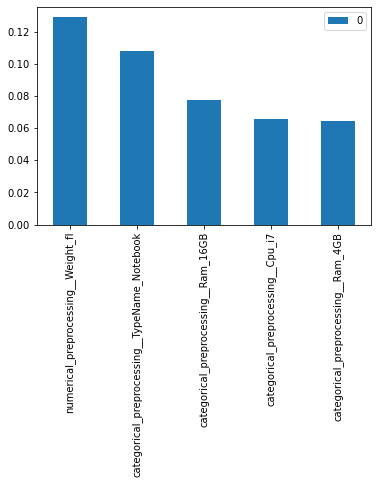

In [92]:
# feature importance coefficients
fi = pipeline.steps[1][1].feature_importances_
# feature names after one hot encoding and scaling
fn = pipeline[:-1].get_feature_names_out()

# combine into dataframe
fi_df = pd.DataFrame(fi, fn)
# plot largest 5 coefficients
fi_df.sort_values(0, ascending = False).head(5).plot.bar()

In [76]:
input_laptop = np.array([['1', 
                         'Microsoft', 
                         'Surface Laptop', 
                         'Ultrabook', 
                         '13.5', 
                         'Touchscreen 1920x1080', 
                         'Intel Core i7 8550U 1.8GHz', 
                         '16GB', 
                         '512GB SSD', 
                         'Intel Iris Pro Graphics',
                         'Windows 10',
                         1.80,
                         '2100']])
input_laptop_df = pd.DataFrame(input_laptop, columns = ['laptop_ID','Company','Product','TypeName','Inches','ScreenResolution','Cpu','Ram','Memory','Gpu','OpSys','Weight_fl','Price_euros'])
input_laptop_df = process_dataframe(input_laptop_df)
input_laptop_df = input_laptop_df.drop('Price_euros', axis = 1)

print(input_laptop_df)

print(pipeline.predict(input_laptop_df))

     Company   TypeName Inches ScreenResolution Cpu   Ram  Memory   Gpu  \
0  Microsoft  Ultrabook   13.5         920x1080  i7  16GB     512  Iris   

        OpSys Weight_fl  Touchscreen  ssd  
0  Windows 10       1.8            1    1  
[2012.46423333]
